# Initialise

In [1]:
import astropy.io.fits as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.io.fits as pf


def rebin(z_old, pdf_old, zbins):
        # spline
        kwargs_spline = {'s': 0,  # force spline to go through data points
                         'ext': 'zeros',  # ext=0 means extrapolate, =1 means return 0
                         'k': 3,
                        }
        spline = UnivariateSpline(z_old, pdf_old, **kwargs_spline)
        pdf = np.zeros(len(zbins) - 1)
        for i in range(len(zbins) - 1):
            zmin = zbins[i]
            zmax = zbins[i + 1]
            pdf[i] = spline.integral(zmin, zmax) #/ (zmax - zmin)
        return pdf
    
def compute_mean(z0,nz0):
    norm0 = 0.
    mean0 = 0.
    for kk in range(len(z0)):
        norm0+=nz0[kk]
        mean0+=nz0[kk]*z0[kk]
    return mean0/norm0
 
    
def compute_std(z0,nz0):
    norm0 = 0.
    mean0 = 0.
    std = 0.
    for kk in range(len(z0)):
        norm0+=nz0[kk]
        mean0+=nz0[kk]*z0[kk]
    mean0 = mean0/norm0
    norm0 = 0.
    for kk in range(len(z0)):
        norm0+=nz0[kk]
        std+=nz0[kk]*(z0[kk]-mean0)**2
    if std>0.and norm0>0.:
        return  np.sqrt(std/norm0)
    else:
    
        return 0.
    
import pickle 
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol = 2)
        f.close()
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute


class WZ_obj(object):
    def __init__(self,dictionary,info):
        self.sompz= None
        
        self.Nz=dict()
        self.Nz_err=dict()
        self.Nz_mean=dict()
        self.Nz_mean_err=dict()
        self.Nz_std=dict()
        self.Nz_std_err=dict()

        self.sompz_mean=dict()
        self.sompz_std=dict()
        
        self.w_ur = dictionary['Nz']
        self.w_rr = dictionary['bz']
        self.w_dm = None
        self.b_corr = None
        self.bz=dict()
        self.bz_err=dict()
        
        self.ntomo = dictionary['Nz'].shape[0]
        self.bins=info['bins']
        self.n_jck = info['n_jck']

        
        self.zmin = info['zmin']
        self.zmax = info['zmax']
        self.z_edges = np.linspace(self.zmin,self.zmax,self.bins+1)
        self.z = 0.5*(self.z_edges[1:]+self.z_edges[:-1])
        self.maskXsigma=None
        
    def shrink_z_interval(self,xd=0,xup=0):
        self.z = self.z[0+xd:len(self.z)-xup]
        self.z_edges = self.z_edges[0+xd:len(self.z_edges)-xup]
        self.bins = self.bins-xd-xup
        
        try:
            self.b_corr = self.b_corr[0+xd:len(self.b_corr)-xup]
        except:
            print('shrinking: nothing to do for b_corr')
    
        try:
            self.w_dm = self.w_dm[0+xd:len(self.w_dm)-xup]
        except:
            print('shrinking: nothing to do for w_dm')
        try:
        
            self.sompz = self.sompz[:,0+xd:len(self.z)]
        except:
            print('shrinking: nothing to do for sompz')

   
        
    def set_b_corr(self,b_corr):
        self.b_corr=b_corr
    def set_wdm(self,w_dm):
        self.w_dm = w_dm
        
    def set_sompz(self,sompz):
        self.sompz = sompz
        
    def compute_Xsigma_sompz(self,sompz,sigma=2):
        print('computing sompz interval at {0} sigma'.format(sigma))
        mask = []
        try:
            for i in range(len(self.sompz)):
            
                sompz_mean = compute_mean(self.z, self.sompz[i])
                sompz_std = compute_std(self.z, self.sompz[i])
                mask.append((self.z < sompz_mean + sigma*sompz_std) & (self.z > sompz_mean - sigma*sompz_std))
                #normalise sompz
                self.sompz[i] = self.sompz[i]/np.trapz(self.sompz[i][mask[i]], x= self.z[mask[i]])
            self.maskXsigma = mask
        except:
            print ('could not compute X sigma interval')
            
    def compute_nz(self,estimators = ['y1','wdm_br','wdm','wdm_brcorr']):
        
        for method in estimators:
            Nz = np.zeros((self.ntomo,self.bins,self.n_jck+1))
            err = np.zeros((self.ntomo,self.bins))
            try:
            #if 1==1:
                for i in range(self.ntomo):
                    for j in range(self.bins):
                        for k in range(self.n_jck+1):
                            if method == 'y1':
                                Nz[i,j,k] = self.w_ur[i,j,k]
                            elif method == 'wdm':
                                Nz[i,j,k] = self.w_ur[i,j,k]/self.w_dm[j]
                            elif method == 'wdm_br':
                                Nz[i,j,k] = self.w_ur[i,j,k]/(np.sqrt(self.w_rr[i,j,k]*self.w_dm[j]))
                            elif method == 'wdm_brcorr':
                                Nz[i,j,k] = self.w_ur[i,j,k]*self.b_corr[j]/(np.sqrt(self.w_rr[i,j,k]*self.w_dm[j]))

                    # normalise to 2 sigma.

                    Nz[i,:,:]= Nz[i,:,:]/np.trapz(Nz[i,:,0][self.maskXsigma[i]], x = self.z[self.maskXsigma[i]])
                    # compute errors.
                    mute_cov = covariance_jck(Nz[i,:,1:],self.n_jck,'jackknife')
                    err[i,:]=mute_cov['err']
                self.Nz[method] = Nz
                self.Nz_err[method] =err
                
            except:
                print ('Method {0} failed'.format(method))
            self.Nz_estimators=self.Nz.keys()
            
    def compute_bias(self,estimators = ['y1','wdm_br','wdm','wdm_brcorr']):
        
        for method in estimators:
            bz = np.zeros((self.ntomo,self.bins,self.n_jck+1))
            bz0 = np.zeros((self.ntomo,self.bins,self.n_jck+1))
            err = np.zeros((self.ntomo,self.bins))
            try:
            #if 1==1:
                for i in range(self.ntomo):
                    for j in range(self.bins):
                        for k in range(self.n_jck+1):
                            bz[i,j,k] = np.sqrt(self.w_rr[i,j,k]/self.w_dm[j])
                            if method == 'wdm_brcorr':
                                bz[i,j,k] = np.sqrt(self.w_rr[i,j,k]/(self.b_corr[j]*self.w_dm[j]))

                    # normalise to 2 sigma.
                    for k in range(self.n_jck+1):
                        bz0[i,:,k]= bz[i,:,k]/np.trapz(bz[i,:,0][self.maskXsigma[i]], x = self.z[self.maskXsigma[i]])
                    # compute errors.
                    mute_cov = covariance_jck(bz0[i,:,1:],self.n_jck,'jackknife')
                    err[i,:]=mute_cov['err']
                self.bz[method] = bz0
                self.bz_err[method] =err
                
            except:
                print ('Method {0} failed'.format(method))
            self.bz_estimators=self.bz.keys()
            
    def compute_mean_std(self):
        for method in self.Nz.keys():
            mean_arr = np.zeros(self.ntomo)
            sompz_mean_arr = np.zeros(self.ntomo)
            mean_err_arr = np.zeros(self.ntomo)
            std_arr = np.zeros(self.ntomo)
            sompz_std_arr = np.zeros(self.ntomo)
            std_err_arr = np.zeros(self.ntomo)
            for i in range(self.ntomo):
                mean_arr[i]= compute_mean(self.z[self.maskXsigma[i]], self.Nz[method][i,:,0][self.maskXsigma[i]])
                mm= covariance_scalar_jck(compute_mean(self.z[self.maskXsigma[i]], self.Nz[method][i,:,1:][self.maskXsigma[i]]),self.n_jck,'jackknife')
                mean_err_arr[i] = mm['err']
                
                std_arr[i]= compute_std(self.z, self.Nz[method][i,:,0])
                mm= covariance_scalar_jck(compute_std(self.z, self.Nz[method][i,:,1:]),self.n_jck,'jackknife')
                std_err_arr[i] = mm['err']
                
                sompz_mean_arr[i]= compute_mean(self.z[self.maskXsigma[i]], self.sompz[i][self.maskXsigma[i]])
                sompz_std_arr[i]= compute_std(self.z, self.sompz[i])
                
            self.Nz_mean[method] = mean_arr
            self.Nz_mean_err[method] = mean_err_arr
            self.Nz_std[method] = std_arr
            self.Nz_std_err[method] = std_err_arr
            self.sompz_mean[method] = sompz_mean_arr
            self.sompz_std[method] = sompz_std_arr
            
            
    def help_me(self):
        print ('ask Marco :)')

# DATA


## read 

In [71]:
data_cosmosis.keys()

['sims_WL_rmg_rmgz_higherlum_data',
 'sims_WL_eboss_large',
 'sims_WL_rmg_rmgz_combined_data_large',
 'sims_WL_rmg_rmgz_combined_data',
 'sims_WL_rmg_rmgz_higherlum_large',
 'data_WL_rmg_rmgz_higherlum',
 'sims_WL_rmg_truez_large',
 'data_WL_rmg_rmgz_combined_large',
 'data_WL_rmg_truez',
 'sims_WL_rmg_truez',
 'data_WL_eboss',
 'data_WL_rmg_rmgz_combined_data',
 'sims_WL_eboss',
 'data_WL_rmg_rmgz_higherlum_data_large',
 'sims_WL_rmg_rmgz_higherlum',
 'data_WL_rmg_truez_large',
 'data_WL_rmg_rmgz_higherlum_data',
 'data_WL_eboss_large',
 'sims_WL_rmg_rmgz_combined',
 'sims_WL_rmg_rmgz_combined_large',
 'data_WL_rmg_rmgz_combined',
 'data_WL_rmg_rmgz_higherlum_large',
 'data_WL_rmg_rmgz_combined_data_large',
 'sims_WL_rmg_rmgz_higherlum_data_large']

In [77]:
# data means the n(z) used as input are the sompz n(z)
# data at the end means that the rmg bins are binned not using the truez
# but the rmg z 

### read sompz

In [2]:
bbb = np.linspace(0.15, 0.95, 26)
print bbb, len(bbb)

eee = np.linspace(0.1, 1.1, 16)
print eee, len(eee)

# zbins_c = bbb[:-1]+ 0.5*(bbb[1]-bbb[0])
# print zbins_c, len(zbins_c)

# zbinse_c = eee[:-1]+ 0.5*(eee[1]-eee[0])
# print zbinse_c, len(zbinse_c)

[0.15  0.182 0.214 0.246 0.278 0.31  0.342 0.374 0.406 0.438 0.47  0.502
 0.534 0.566 0.598 0.63  0.662 0.694 0.726 0.758 0.79  0.822 0.854 0.886
 0.918 0.95 ] 26
[0.1        0.16666667 0.23333333 0.3        0.36666667 0.43333333
 0.5        0.56666667 0.63333333 0.7        0.76666667 0.83333333
 0.9        0.96666667 1.03333333 1.1       ] 16


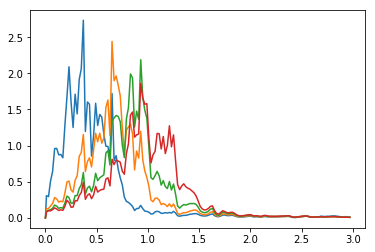

In [3]:
template = pf.open('/global/homes/g/giannini/clustering-z/template_source_nzs_for_mastercat_12_3_19.fits')
#new_template_ = pf.open('/global/cscratch1/sd/jmyles/sompz_buzzard/v0.21/y3_redshift_distributions_v0.21_modal_even.fits')

nz_sompz = pd.DataFrame(template[6].data)

#def rebin(z_old, pdf_old, zbins)
from scipy.interpolate import UnivariateSpline

nz_sompz_25bins = np.empty(shape=(4,25))
nz_sompz_15bins = np.empty(shape=(4,15))
for i in range(4):
    nz_sompz_25bins[i] = rebin(nz_sompz['Z_MID'], nz_sompz['BIN{0}'.format(i+1)], bbb)
    nz_sompz_15bins[i] = rebin(nz_sompz['Z_MID'], nz_sompz['BIN{0}'.format(i+1)], eee)


for i in range(4):
    #integral = np.trapz(nz_sompz['BIN{0}'.format(i)], x = np.linspace(0.15, 0.95-0.033333333333, 24) )
    plt.plot(nz_sompz['Z_MID'], nz_sompz['BIN{0}'.format(i+1)])

### read wz

In [39]:
bias_correction = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/bias_corr')
data_cosmosis = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/dict_cosmosis')

In [4]:
# load theory
bias_correction = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/bias_corr')
data_cosmosis = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/dict_cosmosis')

import sys
sys.path.insert(0, '/global/homes/g/giannini/clustering-z/WZ_utils/')
from covariance_routines import *
from load_routines import *



n_jck=100
gamma = 1
zmin=0.15
zmax=0.95
bins = 25
ang_bins = 8

info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}

path_base = '/global/cscratch1/sd/mgatti/clustering_z/mastercat_12_3_19_'

to_read = [ 'rmg/',
            'rmg_R/',
            'rmg_R_w/',
            'rmg_R_w_1500_5000/',
            #'rmg_high_R/',
            'rmg_higher_R/',
            'rmg_w/']

measured_wz = load_obj('/global/homes/m/mgatti/clustering-z/WZ_cosmosis1')

runs_data = dict()
for ff in to_read:
    #print path_base+ff
#     try:
        dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
        method = ff.strip('/')
        print (method)
        runs_data[method]  = WZ_obj(dictionary,info)
        if '1500_5000' in method:
            runs_data[method].set_wdm(data_cosmosis['sims_WL_rmg_truez_large']['w_rr'][0,:])
        else:
            runs_data[method].set_wdm(data_cosmosis['sims_WL_rmg_truez']['w_rr'][0,:])
        if 'higher' in method:
            runs_data[method].set_b_corr(bias_correction['bias_rmg_corr_higherlum_data'])
        else:
            runs_data[method].set_b_corr(bias_correction['bias_rmg_corr_combined_data'])
        runs_data[method].set_sompz(nz_sompz_25bins)
        runs_data[method].shrink_z_interval(xd=0,xup=1)
        runs_data[method].compute_Xsigma_sompz(nz_sompz_25bins)
        #runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm'])
        runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm','wdm_brcorr'])
        runs_data[method].compute_bias(estimators = ['y1','wdm_br','wdm','wdm_brcorr'])
        runs_data[method].compute_mean_std()
#     except:
#         print (path_base+ff), 'failed'

n_jck=100
gamma = 1
zmin=0.1
zmax=1.1
bins = 15
ang_bins = 8

info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}
     
to_read = [
    'eboss/',
'eboss_R/',
'eboss_R_w/',
'eboss_R_w_1500_5000/',
'eboss_R_w_25_rm/',
'eboss_w/']

        
for ff in to_read:
    try:
        dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
        method = ff.strip('/')
        print (method)
        runs_data[method]  = WZ_obj(dictionary,info)
        if '1500_5000' in method:
            runs_data[method].set_wdm(data_cosmosis['sims_WL_eboss_large']['w_rr'][0,:])
        else:
            runs_data[method].set_wdm(data_cosmosis['sims_WL_eboss']['w_rr'][0,:])
        runs_data[method].set_sompz(nz_sompz_15bins)
        runs_data[method].shrink_z_interval(xd=0,xup=1)
        runs_data[method].compute_Xsigma_sompz(nz_sompz_15bins)
        runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm'])
        runs_data[method].compute_bias(estimators = ['y1','wdm_br','wdm'])
        runs_data[method].compute_mean_std()
    except:
        print (path_base+ff), 'failed'

print ('done')
# '''
# to print the mean:
# runs[method].Nz_mean[estimator][tomobin],runs[method].Nz_mean_err[estimator][tomobin]

# '''

/global/homes/g/giannini/clustering-z/WZ_utils/load_routines.py:25: RuntimeWarning: invalid value encountered in double_scalars
  norm=[1.,ndd/ndr,ndd/nrd,ndd/nrr]
/global/homes/g/giannini/clustering-z/WZ_utils/load_routines.py:52: RuntimeWarning: invalid value encountered in double_scalars
  norm=[1.,ndd/ndr,ndd/nrd,ndd/nrr]


rmg
computing sompz interval at 2 sigma


/global/homes/g/giannini/clustering-z/WZ_utils/covariance_routines.py:68: RuntimeWarning: invalid value encountered in sqrt
  return  np.sqrt(std/norm0)


rmg_R
computing sompz interval at 2 sigma
rmg_R_w
computing sompz interval at 2 sigma
rmg_R_w_1500_5000
computing sompz interval at 2 sigma
rmg_higher_R
computing sompz interval at 2 sigma
rmg_w
computing sompz interval at 2 sigma
eboss
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R_w
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R_w_1500_5000
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R_w_25_rm
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_w
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
done


## mean

In [261]:
for i in range(4):
    print '\n'
    print 'BIN ', i 
    for est in ['wdm_brcorr']: #runs_data['rmg'].Nz.keys():
        print '------'
        print est
        print '------'

        for method in ['rmg_higher_R']: #runs_data.keys():
            try:
                print method
                print '-'
                print 'shift        {0:2.3f}'.format(runs_data[method].sompz_mean[est][i]-runs_data[method].Nz_mean[est][i])
                print 'shifterr     {0:2.4f}'.format(2*runs_data[method].Nz_mean_err[est][i])
                print 'mean         {0:2.3f}'.format(runs_data[method].Nz_mean[est][i])
                print 'meanerr      {0:2.4f}'.format(runs_data[method].Nz_mean_err[est][i])
                print 'std          {0:2.3f}'.format(runs_data[method].Nz_std[est][i])
                print 'stderr       {0:2.3f}'.format(runs_data[method].Nz_std_err[est][i])
                print 
            except: 
                print 'eboss does not have {0} estimator'.format(est)
                continue



BIN  0
------
wdm_brcorr
------
rmg_higher_R
-
shift        -0.001
shifterr     0.0065
mean         0.424
meanerr      0.0032
std          0.158
stderr       0.003



BIN  1
------
wdm_brcorr
------
rmg_higher_R
-
shift        -0.025
shifterr     0.0057
mean         0.635
meanerr      0.0029
std          0.173
stderr       0.003



BIN  2
------
wdm_brcorr
------
rmg_higher_R
-
shift        -0.047
shifterr     0.0078
mean         0.734
meanerr      0.0039
std          0.162
stderr       0.007



BIN  3
------
wdm_brcorr
------
rmg_higher_R
-
shift        -0.062
shifterr     0.0241
mean         0.751
meanerr      0.0121
std          0.160
stderr       0.023



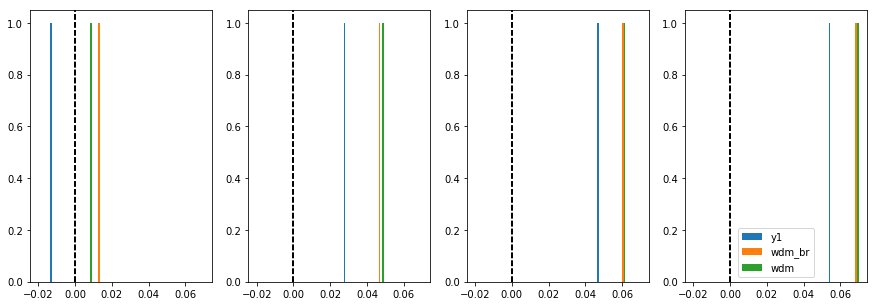

In [418]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
for i in range(4):
    for est in runs_data['rmg'].Nz.keys():
        ax[i].hist(runs_data['rmg_R_w'].Nz_mean[est][i]-runs_data['rmg_R_w'].sompz_mean[est][i], bins = np.linspace(-0.02, 0.07, 100), label = '{0}'.format(est))
        ax[i].axvline(linestyle = '--', color = 'black')
plt.legend()

## Plots Data

### rm

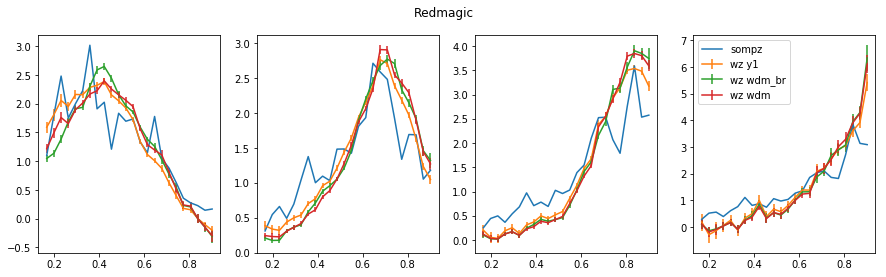

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['rmg_R_w'].z
    ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
    for est in runs_data['rmg_R_w'].Nz_mean.keys():
        ax[i].errorbar(z, runs_data['rmg_R_w'].Nz[est][i,:,0], runs_data['rmg_R_w'].Nz_err[est][i,:], label='wz {0}'.format(est))         
plt.suptitle('Redmagic wz')
plt.legend()

### eboss

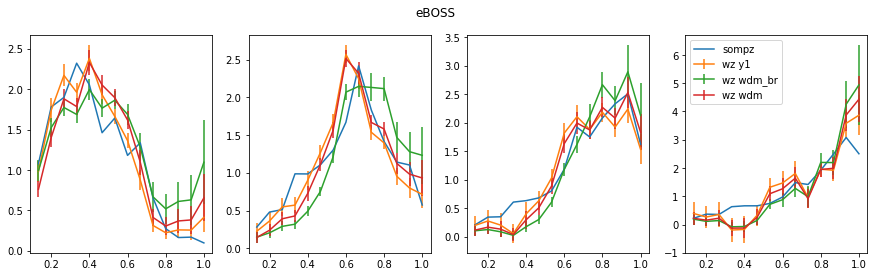

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['eboss_R_w'].z
    ax[i].errorbar(z, runs_data['eboss_R_w'].sompz[i], label='sompz')         
    for est in runs_data['eboss_R_w'].Nz_mean.keys():
        ax[i].errorbar(z, runs_data['eboss_R_w'].Nz[est][i,:,0], runs_data['eboss_R_w'].Nz_err[est][i,:], label='wz {0}'.format(est))         
plt.suptitle('eBOSS')
plt.legend()

### small vs large scales

In [349]:
runs_data.keys()

['rmg_R_w',
 'rmg_R',
 'rmg_w',
 'eboss_R_w_1500_5000',
 'eboss_w',
 'eboss_R',
 'rmg_R_w_1500_5000',
 'eboss_R_w',
 'rmg',
 'eboss',
 'eboss_R_w_25_rm']

In [352]:
runs_data['rmg_R_w_1500_5000'].Nz.keys()

['y1', 'wdm_br', 'wdm']

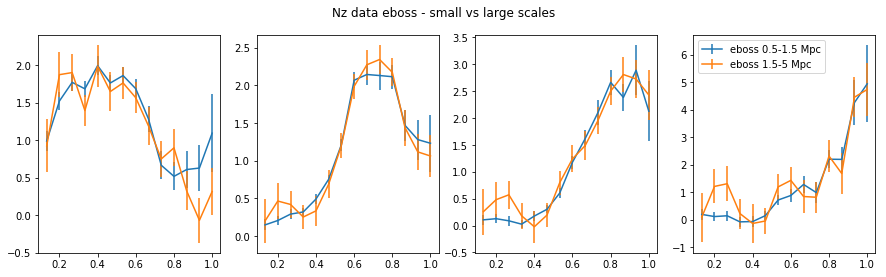

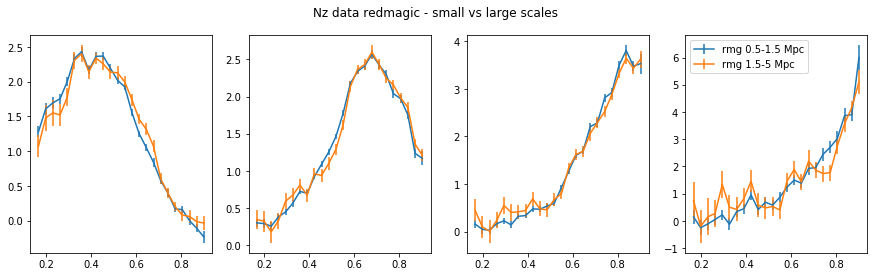

In [209]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['eboss_R_w'].z
    #ax[i].errorbar(z, runs_data['eboss_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_data['eboss_R_w'].Nz['wdm_br'][i,:,0], runs_data['eboss_R_w'].Nz_err['wdm_br'][i,:], label='eboss 0.5-1.5 Mpc')         
    ax[i].errorbar(z, runs_data['eboss_R_w_1500_5000'].Nz['wdm_br'][i,:,0], runs_data['eboss_R_w_1500_5000'].Nz_err['wdm_br'][i,:], label='eboss 1.5-5 Mpc')         
plt.suptitle('Nz data eboss - small vs large scales')
plt.legend(loc = 2)
plt.savefig('./nz_data_eboss_small_large.pdf',bbox_inches='tight')
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['rmg_R_w'].z
    #ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_data['rmg_R_w'].Nz['wdm_brcorr'][i,:,0], runs_data['rmg_R_w'].Nz_err['wdm_brcorr'][i,:], label='rmg 0.5-1.5 Mpc')         
    ax[i].errorbar(z, runs_data['rmg_R_w_1500_5000'].Nz['wdm_brcorr'][i,:,0], runs_data['rmg_R_w_1500_5000'].Nz_err['wdm_brcorr'][i,:], label='rmg 1.5-5 Mpc')         
plt.suptitle('Nz data redmagic - small vs large scales')

plt.legend()

plt.savefig('./nz_data_rm_small_large.pdf',bbox_inches='tight')

## test weights and response function

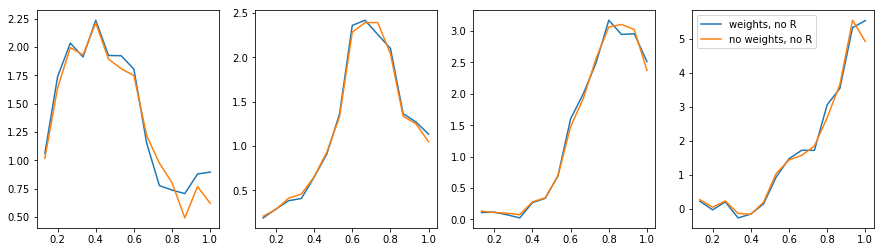

In [246]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    #ax[i].plot(zbinse_c, runs_eboss[0]['Nz'][i,:,0][:14]/(measured_wz['th_correction_eboss']**2*int_eboss[0][i]), label = 'weights, R no b')
    #ax[i].plot(zbins_c, runs_eboss[0]['Nz'][i,:,0][:14]/(inte_ebossgral[0][i]), label = 'weights, R no b')
    
    #ax[i].plot(zbinse_c, runs_eboss[0]['Nz'][i,:14,0]/(np.sqrt(runs_eboss[0]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])*int_eboss[0][i]), label = 'weights, R')
    ax[i].plot(zbinse_c, runs_eboss[1]['Nz'][i,:14,0]/(np.sqrt(runs_eboss[1]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])*int_eboss[1][i]), label = 'weights, no R')
    #ax[i].plot(zbinse_c, runs_eboss[2]['Nz'][i,:14,0]/(np.sqrt(runs_eboss[2]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])*int_eboss[2][i]), label = 'no weights, R')
    ax[i].plot(zbinse_c, runs_eboss[3]['Nz'][i,:14,0]/(np.sqrt(runs_eboss[3]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])*int_eboss[3][i]), label = 'no weights, no R')

ax[3].legend()


In [ ]:
for i in range(4):
    print i 
    miao = dict()
    print 'w r ', compute_std(zbinse_c[:14], runs[0]['Nz'][i,:14,0]/(np.sqrt(runs[0]['bz'][i,:14,0]*measured_wz['th_correction_eboss'])))
    #print miao['y3mean'], miao['y3std']
    mask = (zbinse_c[:14] < (miao['y3mean']+2*miao['y3std'])) &  (zbins_c[:24] > (miao['y3mean']-2*miao['y3std']))
    #print mask, len(mask)
    miao['y3mean_2s'] = compute_mean(zbins_c[:24][mask], (runs[0]['Nz'][i,:24,0]/(np.sqrt(runs[0]['bz'][i,:24,0]*measured_wz['th_correction'])))[mask])
    b = np.zeros((100))
    for j in range(100):
        b[j] = compute_mean(zbins_c[:24][mask], (runs[0]['Nz'][i,:24,j+1]/(np.sqrt(runs[0]['bz'][i,:24,j+1]*measured_wz['th_correction'])))[mask]) 
    miao['y3mean_2s_err'] = covariance_scalar_jck(b,100,'jackknife')
    

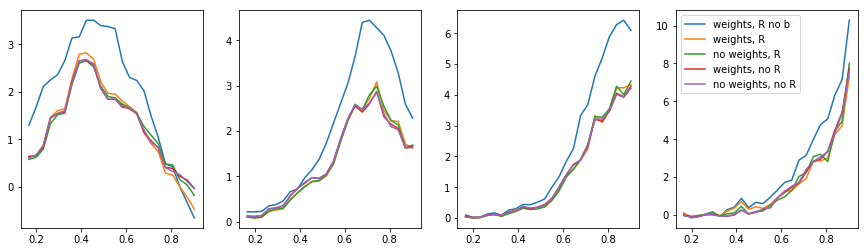

In [178]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/(measured_wz['th_correction']**2*integral[0][i]), label = 'weights, R no b')
    #ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/(integral[0][i]), label = 'weights, R no b')
    
    ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/(runs[0]['bz'][i,:24,0]*measured_wz['th_correction']*integral[0][i]), label = 'weights, R')
    ax[i].plot(zbins_c[:24], runs[1]['Nz'][i,:,0][:24]/(runs[1]['bz'][i,:24,0]*measured_wz['th_correction']*integral[1][i]), label = 'no weights, R')
    ax[i].plot(zbins_c[:24], runs[2]['Nz'][i,:,0][:24]/(runs[2]['bz'][i,:24,0]*measured_wz['th_correction']*integral[2][i]), label = 'weights, no R')
    ax[i].plot(zbins_c[:24], runs[3]['Nz'][i,:,0][:24]/(runs[3]['bz'][i,:24,0]*measured_wz['th_correction']*integral[3][i]), label = 'no weights, no R')

ax[3].legend()


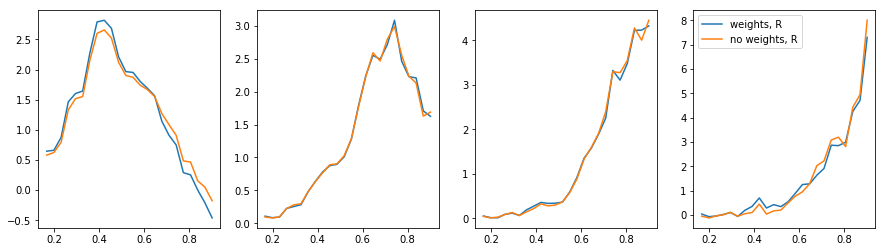

In [173]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/(runs[0]['bz'][i,:24,0]*measured_wz['th_correction']*integral[0][i]), label = 'weights, R')
    ax[i].plot(zbins_c[:24], runs[1]['Nz'][i,:,0][:24]/(runs[1]['bz'][i,:24,0]*measured_wz['th_correction']*integral[1][i]), label = 'no weights, R')

ax[3].legend()


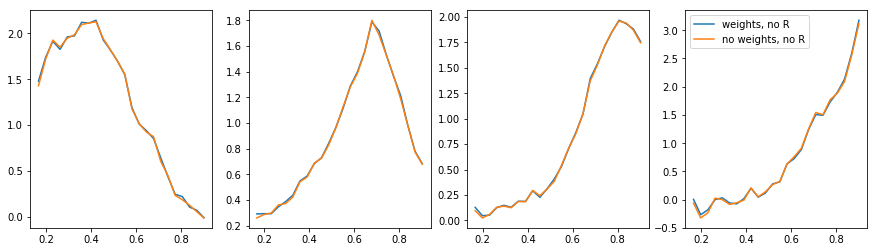

In [167]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[2]['Nz'][i,:,0][:24]/integral[2][i], label = 'weights, no R')
    ax[i].plot(zbins_c[:24], runs[3]['Nz'][i,:,0][:24]/integral[3][i], label = 'no weights, no R')

ax[3].legend()


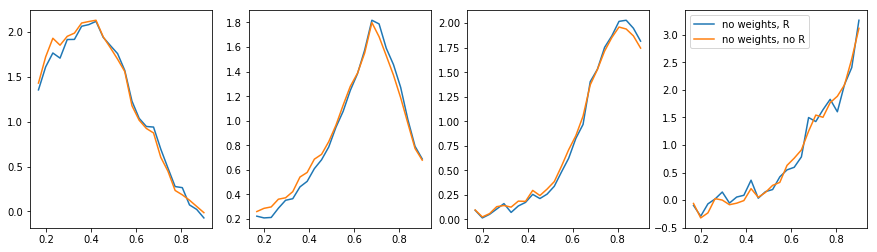

In [166]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[1]['Nz'][i,:,0][:24]/integral[1][i], label = 'no weights, R')
    ax[i].plot(zbins_c[:24], runs[3]['Nz'][i,:,0][:24]/integral[3][i], label = 'no weights, no R')

ax[3].legend()


In [193]:
integral.shape

(4, 4)

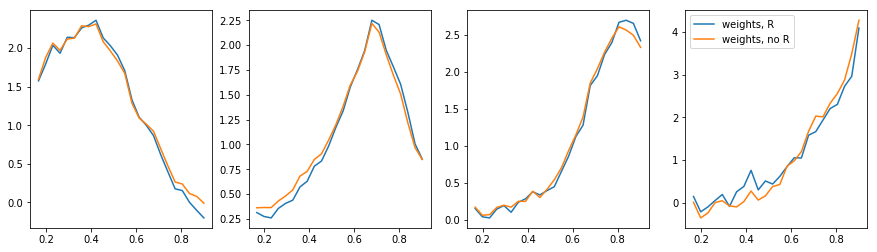

In [194]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    ax[i].plot(zbins_c[:24], runs[0]['Nz'][i,:,0][:24]/integral[0][i], label = 'weights, R')
    ax[i].plot(zbins_c[:24], runs[2]['Nz'][i,:,0][:24]/integral[2][i], label = 'weights, no R')
    
ax[3].legend()


## comparison rm vs eboss

In [237]:
# load theory
bias_correction = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/bias_corr')
data_cosmosis = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/dict_cosmosis')

import sys
sys.path.insert(0, '/global/homes/g/giannini/clustering-z/WZ_utils/')
from covariance_routines import *
from load_routines import *



path_base = '/global/cscratch1/sd/mgatti/clustering_z/mastercat_12_3_19_'



measured_wz = load_obj('/global/homes/m/mgatti/clustering-z/WZ_cosmosis1')

runs_data_comp = dict()


n_jck=100
gamma = 1
zmin=0.1
zmax=1.1
bins = 15
ang_bins = 8

info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}
     
to_read = [
    'eboss/',
'eboss_R/',
'eboss_R_w/',
'eboss_R_w_1500_5000/',
'eboss_R_w_25_rm/',
'eboss_w/']

        
for ff in to_read:
    try:
        dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
        method = ff.strip('/')
        print (method)
        runs_data_comp[method]  = WZ_obj(dictionary,info)
        if '1500_5000' in method:
            runs_data_comp[method].set_wdm(data_cosmosis['sims_WL_eboss_large']['w_rr'][0,:])
        else:
            runs_data_comp[method].set_wdm(data_cosmosis['sims_WL_eboss']['w_rr'][0,:])
        runs_data_comp[method].set_sompz(nz_sompz_15bins)
        runs_data_comp[method].shrink_z_interval(xd=0,xup=2)
        runs_data_comp[method].compute_Xsigma_sompz(nz_sompz_15bins)
        runs_data_comp[method].compute_nz(estimators = ['y1','wdm_br','wdm'])
        runs_data_comp[method].compute_bias(estimators = ['y1','wdm_br','wdm'])
        #runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm','wdm_brcorr'])
        runs_data_comp[method].compute_mean_std()
    except:
        print (path_base+ff), 'failed'

print ('done')
# '''
# to print the mean:
# runs[method].Nz_mean[estimator][tomobin],runs[method].Nz_mean_err[estimator][tomobin]

# '''

eboss
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R_w
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R_w_1500_5000
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R_w_25_rm
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_w
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
done


In [331]:
runs_data['rmg_R_w'].sompz[i].shape

(24,)

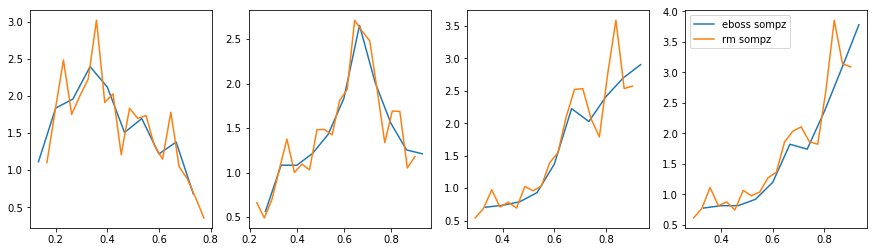

In [74]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    mask_sompz = runs_data_comp['eboss_R_w'].maskXsigma
    z = runs_data_comp['eboss_R_w'].z[mask_sompz[i]]
    #print z
    ax[i].errorbar(z, runs_data_comp['eboss_R_w'].sompz[i][mask_sompz[i]], label='eboss sompz')         
    mask_sompz = runs_data['rmg_R_w'].maskXsigma
    z = runs_data['rmg_R_w'].z[mask_sompz[i]]
    #print z
    ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i][mask_sompz[i]], label='rm sompz')         
plt.legend()

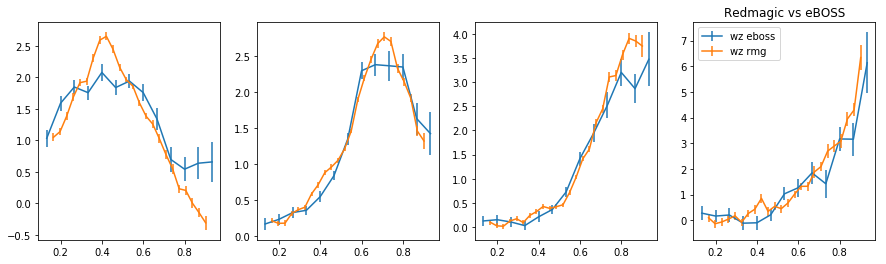

In [238]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data_comp['eboss_R_w'].z
    #ax[i].errorbar(z, runs_data['eboss_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_data_comp['eboss_R_w'].Nz['wdm_br'][i,:,0], runs_data_comp['eboss_R_w'].Nz_err['wdm_br'][i,:], label='wz eboss')         
    z = runs_data['rmg_R_w'].z
    ax[i].errorbar(z, runs_data['rmg_R_w'].Nz['wdm_br'][i,:,0], runs_data['rmg_R_w'].Nz_err['wdm_br'][i,:], label='wz rmg')         
plt.legend()
plt.title('Redmagic vs eBOSS')
plt.savefig('./nz_rm_eboss.pdf')

In [242]:
runs_data.keys()

['rmg_R',
 'rmg_R_w',
 'rmg_w',
 'eboss_R_w_1500_5000',
 'eboss_w',
 'eboss_R',
 'rmg_R_w_1500_5000',
 'eboss_R_w',
 'rmg',
 'eboss',
 'rmg_higher_R',
 'eboss_R_w_25_rm']

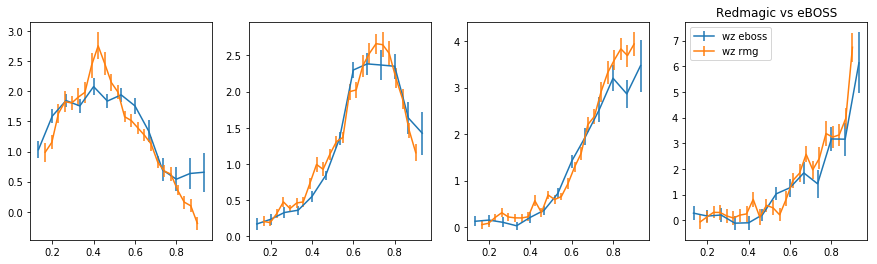

In [243]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data_comp['eboss_R_w'].z
    #ax[i].errorbar(z, runs_data['eboss_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_data_comp['eboss_R_w'].Nz['wdm_br'][i,:,0], runs_data_comp['eboss_R_w'].Nz_err['wdm_br'][i,:], label='wz eboss')         
    z = runs_data['rmg_higher_R'].z
    ax[i].errorbar(z, runs_data['rmg_higher_R'].Nz['wdm_br'][i,:,0], runs_data['rmg_higher_R'].Nz_err['wdm_br'][i,:], label='wz rmg')         
plt.legend()
plt.title('Redmagic vs eBOSS')
plt.savefig('./nz_rm_higherlum_eboss.pdf')

In [345]:
runs_data['eboss_R_w'].Nz['y1'].shape

(4, 14, 101)

In [264]:
runs_data_comp.keys()

['eboss_R_w_1500_5000',
 'eboss_w',
 'eboss_R',
 'eboss_R_w',
 'eboss',
 'eboss_R_w_25_rm']

In [265]:
for i in range(4):
    print '\n'
    print 'BIN ', i 
    for est in ['wdm_br']: #runs_data_comp['eboss'].Nz.keys():
        print '------'
        print est
        print '------'

        for method in ['eboss_R_w']: #runs_data_comp.keys():
            
            print method
            print '-'
            print 'shift        {0:2.3f}'.format(runs_data_comp[method].sompz_mean[est][i]-runs_data_comp[method].Nz_mean[est][i])
            print 'shifterr     {0:2.4f}'.format(2*runs_data_comp[method].Nz_mean_err[est][i])
            print 'mean         {0:2.3f}'.format(runs_data_comp[method].Nz_mean[est][i])
            print 'meanerr      {0:2.4f}'.format(runs_data_comp[method].Nz_mean_err[est][i])
            print 'std          {0:2.3f}'.format(runs_data_comp[method].Nz_std[est][i])
            print 'stderr       {0:2.3f}'.format(runs_data_comp[method].Nz_std_err[est][i])
            print 




BIN  0
------
wdm_br
------
eboss_R_w
-
shift        -0.018
shifterr     0.0123
mean         0.423
meanerr      0.0061
std          0.211
stderr       0.009



BIN  1
------
wdm_br
------
eboss_R_w
-
shift        -0.050
shifterr     0.0110
mean         0.684
meanerr      0.0055
std          0.178
stderr       0.006



BIN  2
------
wdm_br
------
eboss_R_w
-
shift        -0.048
shifterr     0.0146
mean         0.772
meanerr      0.0073
std          0.157
stderr       0.012



BIN  3
------
wdm_br
------
eboss_R_w
-
shift        -0.073
shifterr     0.0303
mean         0.810
meanerr      0.0152
std          0.164
stderr       0.030



# SIMS

#### sompz

In [7]:
import h5py

In [8]:
path= '/global/project/projectdirs/des/jderose/Chinchilla/Herd/Chinchilla-3/v1.9.8/sampleselection/Y3a/mastercat/'
version = 'v1.9.8_Y3a'
mastercat = h5py.File(path+'Buzzard-3_'+version+'_mastercat.h5','r')

In [9]:
mask_select = np.array(mastercat['index/select'])

In [10]:
dnf_id = np.array(mastercat['catalog/dnf/unsheared/coadd_object_id'])
bpz_id = np.array(mastercat['catalog/bpz/unsheared/coadd_object_id'])

In [11]:
dnf = np.array(mastercat['catalog/dnf/unsheared/z'])[mask_select]
bpz = np.array(mastercat['catalog/bpz/unsheared/z'])[mask_select]

In [12]:
Z_LOW = np.array(mastercat['catalog/sompz/pzdata/zlow'])
Z_HIGH = np.array(mastercat['catalog/sompz/pzdata/zhigh'])

In [13]:
sompz_id = np.array(mastercat['catalog/sompz/unsheared/coadd_object_id'])[mask_select]

In [14]:
len(sompz_id)

127166591

In [15]:
import matplotlib.pyplot as plt

(array([476795., 170766., 336230.,      0.,      0.,      0.,      0.,
         11809., 263683.,  12383.]),
 array([0.00000000e+00, 4.30012999e+10, 8.60025998e+10, 1.29003900e+11,
        1.72005200e+11, 2.15006499e+11, 2.58007799e+11, 3.01009099e+11,
        3.44010399e+11, 3.87011699e+11, 4.30012999e+11]),
 <a list of 10 Patch objects>)

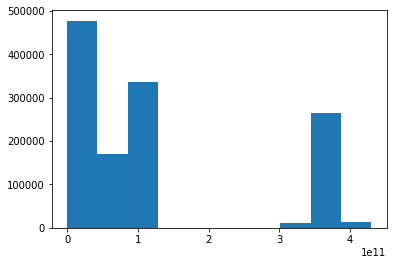

In [16]:
plt.hist(sompz_id[1::100])

In [17]:
bhat = np.array(mastercat['catalog/sompz/unsheared/bhat'])[mask_select]

In [18]:
sompz_dict = dict()

for t in range(4):
    sompz_dict[t] = bpz[bhat == t]

In [19]:
Z_MID = (Z_LOW+Z_HIGH)/2

In [20]:
nz_sompz = np.zeros((4,len(Z_MID)))

for t in range(4):
    for i in range(len(Z_MID)):

        mask_bin = (sompz_dict[t]<Z_HIGH[i]) & (sompz_dict[t]>Z_LOW[i])
        #print len(mask_bin)
        nz_sompz[t][i] = len(sompz_dict[t][mask_bin])

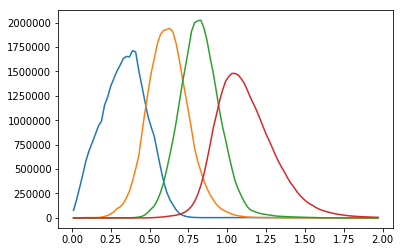

In [21]:
for t in range(4):
    plt.plot(Z_MID, nz_sompz[t])

In [22]:
bbb = np.linspace(0.15, 0.95, 26)
print bbb, len(bbb)

eee = np.linspace(0.1, 1.1, 16)
print eee, len(eee)

[0.15  0.182 0.214 0.246 0.278 0.31  0.342 0.374 0.406 0.438 0.47  0.502
 0.534 0.566 0.598 0.63  0.662 0.694 0.726 0.758 0.79  0.822 0.854 0.886
 0.918 0.95 ] 26
[0.1        0.16666667 0.23333333 0.3        0.36666667 0.43333333
 0.5        0.56666667 0.63333333 0.7        0.76666667 0.83333333
 0.9        0.96666667 1.03333333 1.1       ] 16


In [23]:
#sims
from scipy.interpolate import UnivariateSpline

nz_sompz_25bins_sims = np.empty(shape=(4,25))
nz_sompz_15bins_sims = np.empty(shape=(4,15))
for t in range(4):
    nz_sompz_25bins_sims[t] = rebin(Z_MID, nz_sompz[t], bbb)
    nz_sompz_15bins_sims[t] = rebin(Z_MID, nz_sompz[t], eee)


In [24]:
save_obj('nz_sompz_15bins_sims', nz_sompz_15bins_sims)
save_obj('nz_sompz_25bins_sims', nz_sompz_25bins_sims)

### read wz sims

In [17]:
import sys

sys.path.insert(0, '/global/homes/g/giannini/clustering-z/WZ_utils/')
from covariance_routines import *
from load_routines import *

measured_wz = load_obj('/global/homes/m/mgatti/clustering-z/WZ_cosmosis1')

In [21]:
bias_correction = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/bias_corr')
data_cosmosis = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/dict_cosmosis')

In [146]:
bias_correction.keys()

['bias_rmg_corr_higherlum_data',
 'bias_rmg_corr_combined',
 'bias_rmg_corr_higherlum',
 'bias_rmg_corr_combined_data']

In [25]:
n_jck=100
gamma = 1
zmin=0.15
zmax=0.95
bins = 25
ang_bins = 8
info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}

path_base = '/global/cscratch1/sd/mgatti/clustering_z/cross_corr_'


to_read = ['rmgz_higherlum/',
#           'rmgz_highlum/',
           'rmgz/',
           'truez_higherlum/',
#           'truez_highlum/',
           'truez/',
           'truez_1500_5000kpc/',
           'rmgz_1500_5000kpc/',
]


runs_sims = dict()
for ff in to_read:
    dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
    method = ff.strip('/')
    #print (method)
    runs_sims[method]  = WZ_obj(dictionary,info)
    if '1500_5000' in method:
        runs_sims[method].set_wdm(data_cosmosis['sims_WL_rmg_truez_large']['w_rr'][0,:])
    else:
        runs_sims[method].set_wdm(data_cosmosis['sims_WL_rmg_truez']['w_rr'][0,:])
    if 'higherlum' in method:
        runs_sims[method].set_b_corr(bias_correction['bias_rmg_corr_higherlum_data'])
    else:
        runs_sims[method].set_b_corr(bias_correction['bias_rmg_corr_combined_data'])
    runs_sims[method].set_sompz(nz_sompz_25bins_sims)
    runs_sims[method].shrink_z_interval(xd=0,xup=1)
    runs_sims[method].compute_Xsigma_sompz(nz_sompz_25bins_sims)
    runs_sims[method].compute_nz(estimators = ['y1','wdm_br','wdm', 'wdm_brcorr'])
    runs_sims[method].compute_bias(estimators = ['y1','wdm_br','wdm', 'wdm_brcorr'])
    runs_sims[method].compute_mean_std()
    #print path_base+ff
#     try:
        

#     except:
#         print (path_base+ff), 'failed'

'''
runs[method].Nz_mean[estimator][tomobin],runs[method].Nz_mean_err[estimator][tomobin]

'''

computing sompz interval at 2 sigma
computing sompz interval at 2 sigma
computing sompz interval at 2 sigma
computing sompz interval at 2 sigma
computing sompz interval at 2 sigma
computing sompz interval at 2 sigma


'\nruns[method].Nz_mean[estimator][tomobin],runs[method].Nz_mean_err[estimator][tomobin]\n\n'

In [30]:
n_jck=100
gamma = 1
zmin=0.1
zmax=1.1
bins = 15
ang_bins = 8
info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}

path_base = '/global/cscratch1/sd/mgatti/clustering_z/cross_corr_'

to_read = ['eboss_w/',
           'eboss_w_1500_5000/',
]


for ff in to_read:
    #print path_base+ff
    try:
        dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
        method = ff.strip('/')
        #print (method)
        runs_sims[method]  = WZ_obj(dictionary,info)
        if '1500_5000' in method:
            runs_sims[method].set_wdm(data_cosmosis['sims_WL_eboss_large']['w_rr'][0,:])
        else:
            runs_sims[method].set_wdm(data_cosmosis['sims_WL_eboss']['w_rr'][0,:])
        runs_sims[method].set_sompz(nz_sompz_15bins_sims)
        runs_sims[method].shrink_z_interval(xd=0,xup=1)
        runs_sims[method].compute_Xsigma_sompz(nz_sompz_15bins_sims)
        runs_sims[method].compute_nz(estimators = ['y1','wdm_br','wdm'])
        runs_sims[method].compute_bias(estimators = ['y1','wdm_br','wdm'])
        runs_sims[method].compute_mean_std()

    except:
        print (path_base+ff), 'failed'

shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma


In [85]:
runs_sims.keys()

['rmgz_highlum',
 'rmgz_1500_5000kpc',
 'rmgz_higherlum',
 'eboss',
 'eboss_1500_5000kpc',
 'truez',
 'rmgz',
 'truez_1500_5000kpc']

In [ ]:

to_read = ['rmgz_higherlum/',
           'rmgz_highlum/',
           'rmgz/',
           'truez_higherlum/',
#           'truez_highlum/',
           'truez/',
           'truez_1500_5000kpc/',
           'rmgz_1500_5000kpc/',
]

## mean

In [157]:
for i in range(4):
    print '\n'
    print 'BIN ', i 
    for est in runs_sims['rmgz'].Nz.keys():
        print '------'
        print est
        print '------'

        for method in runs_sims.keys():
            try: 

                print method
                print '-'
                print 'shift        {0:2.3f}'.format(runs_sims[method].sompz_mean[est][i]-runs_sims[method].Nz_mean[est][i])
                print 'shifterr     {0:2.4f}'.format(2*runs_sims[method].Nz_mean_err[est][i])
                print 'mean         {0:2.3f}'.format(runs_sims[method].Nz_mean[est][i])
                print 'meanerr      {0:2.4f}'.format(runs_sims[method].Nz_mean_err[est][i])
                print 'std          {0:2.3f}'.format(runs_sims[method].Nz_std[est][i])
                print 'stderr       {0:2.3f}'.format(runs_sims[method].Nz_std_err[est][i])
                print 
            except: 
                print 'eboss does not have {0} estimator'.format(est)
                continue



BIN  0
------
y1
------
rmgz_1500_5000kpc
-
shift        0.012
shifterr     0.0014
mean         0.346
meanerr      0.0007
std          0.117
stderr       0.003

rmgz_higherlum
-
shift        0.027
shifterr     0.0013
mean         0.331
meanerr      0.0006
std          0.099
stderr       0.004

eboss_w
-
shift        0.029
shifterr     0.0095
mean         0.318
meanerr      0.0047
std          0.119
stderr       0.036

truez_higherlum
-
shift        0.025
shifterr     0.0013
mean         0.333
meanerr      0.0007
std          0.105
stderr       0.004

truez
-
shift        0.020
shifterr     0.0007
mean         0.338
meanerr      0.0003
std          0.137
stderr       0.001

rmgz
-
shift        0.021
shifterr     0.0006
mean         0.337
meanerr      0.0003
std          0.143
stderr       0.001

truez_1500_5000kpc
-
shift        0.012
shifterr     0.0013
mean         0.346
meanerr      0.0006
std          0.114
stderr       0.003

eboss_w_1500_5000
-
shift        0.014
shifterr     0.

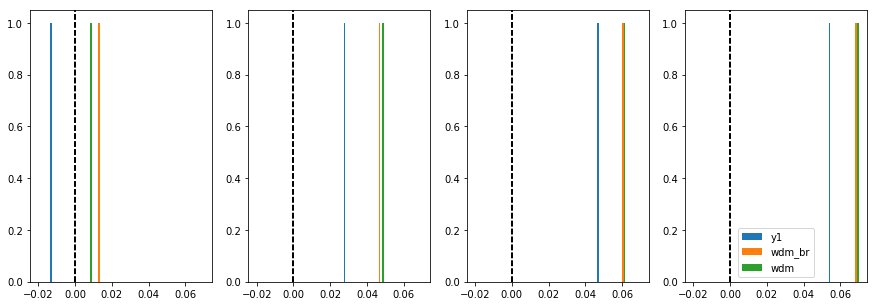

In [418]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))
for i in range(4):
    for est in runs_data['rmg'].Nz.keys():
        ax[i].hist(runs_data['rmg_R_w'].Nz_mean[est][i]-runs_data['rmg_R_w'].sompz_mean[est][i], bins = np.linspace(-0.02, 0.07, 100), label = '{0}'.format(est))
        ax[i].axvline(linestyle = '--', color = 'black')
plt.legend()

## Plots Sims

Text(0.5,0.98,'redmagic - small vs large scales')

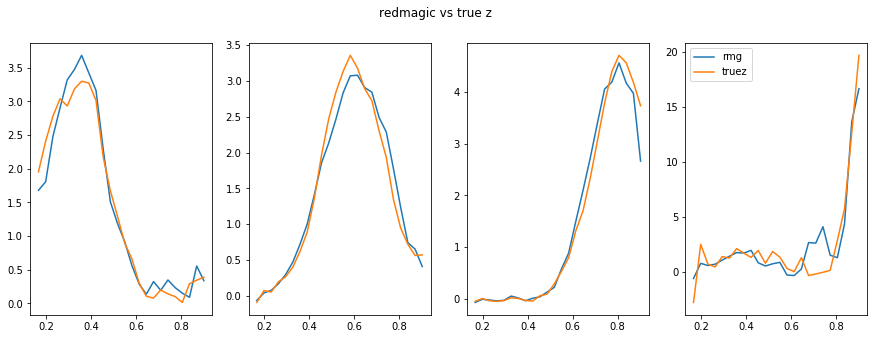

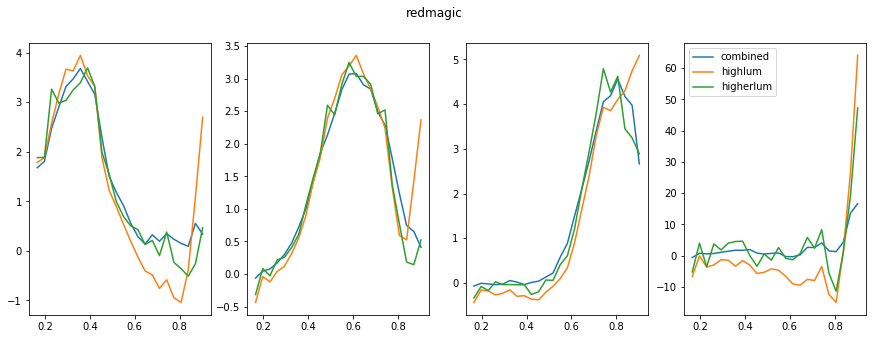

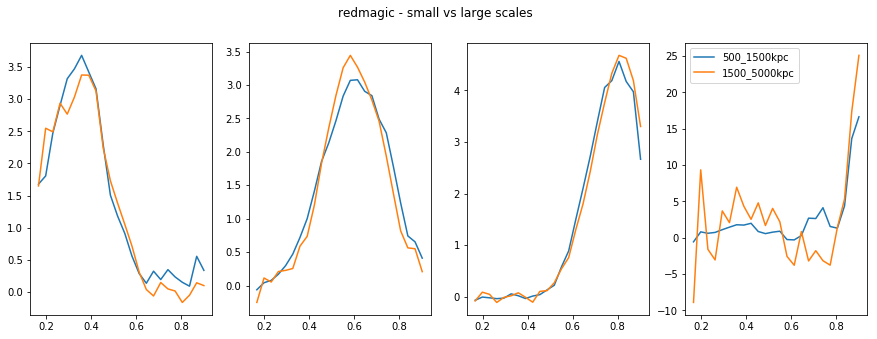

In [33]:
fig, ax = plt.subplots(1, 4, figsize = (15,5))
for t in range(4):
    for est in ['wdm_br']:
        ax[t].plot(runs_sims['rmgz'].z, runs_sims['rmgz'].Nz[est][t, :, 0], label = 'rmg')
        ax[t].plot(runs_sims['truez'].z, runs_sims['truez'].Nz[est][t, :, 0], label = 'truez')
plt.legend()
plt.suptitle('redmagic vs true z')

fig, ax = plt.subplots(1, 4, figsize = (15,5))
for t in range(4):
    for est in ['wdm_br']:
        ax[t].plot(runs_sims['rmgz'].z, runs_sims['rmgz'].Nz[est][t, :, 0], label = 'combined')
        ax[t].plot(runs_sims['rmgz_highlum'].z, runs_sims['rmgz_highlum'].Nz[est][t, :, 0], label = 'highlum')
        ax[t].plot(runs_sims['rmgz_higherlum'].z, runs_sims['rmgz_higherlum'].Nz[est][t, :, 0], label = 'higherlum')
plt.legend()
plt.suptitle('redmagic')

fig, ax = plt.subplots(1, 4, figsize = (15,5))
for t in range(4):
    for est in ['wdm_br']:
        ax[t].plot(runs_sims['rmgz'].z, runs_sims['rmgz'].Nz[est][t, :, 0], label = '500_1500kpc')
        ax[t].plot(runs_sims['rmgz_1500_5000kpc'].z, runs_sims['rmgz_1500_5000kpc'].Nz[est][t, :, 0], label = '1500_5000kpc')
plt.legend()
plt.suptitle('redmagic - small vs large scales')


### rm

In [88]:
runs_sims.keys()

['rmgz_highlum',
 'rmgz_1500_5000kpc',
 'rmgz_higherlum',
 'eboss_w',
 'truez_higherlum',
 'truez',
 'rmgz',
 'truez_1500_5000kpc',
 'eboss_w_1500_5000']

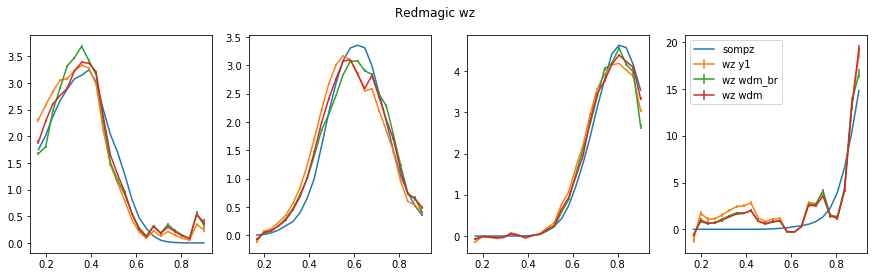

In [90]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_sims['rmgz'].z
    ax[i].errorbar(z, runs_sims['rmgz'].sompz[i], label='sompz')         
    for est in runs_sims['rmgz'].Nz_mean.keys():
        ax[i].errorbar(z, runs_sims['rmgz'].Nz[est][i,:,0], runs_sims['rmgz'].Nz_err[est][i,:], label='wz {0}'.format(est))         
plt.suptitle('Redmagic wz')
plt.legend()

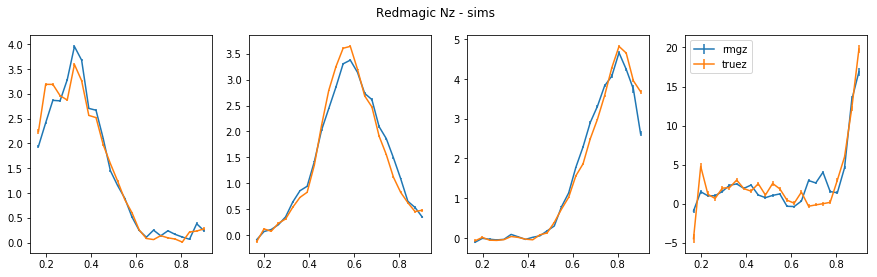

In [223]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_sims['rmgz'].z
    ax[i].errorbar(z, runs_sims['rmgz'].Nz['wdm_brcorr'][i,:,0], runs_sims['rmgz'].Nz_err['wdm_brcorr'][i,:], label='rmgz')         
    ax[i].errorbar(z, runs_sims['truez'].Nz['wdm_brcorr'][i,:,0], runs_sims['truez'].Nz_err['wdm_brcorr'][i,:], label='truez')         
plt.suptitle('Redmagic Nz - sims')
plt.legend()
plt.savefig('./nz_rmg_sims_true.pdf')

### eboss

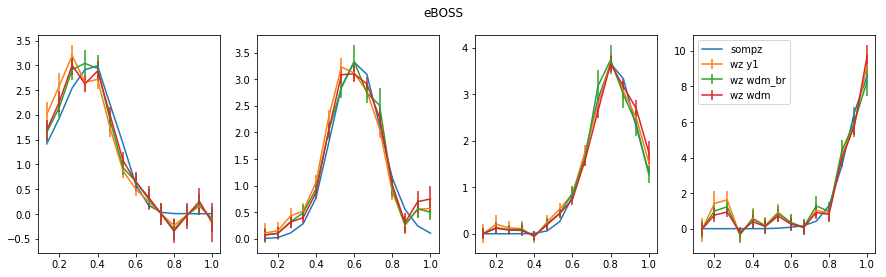

In [92]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
met = 'eboss_w'
for i in range(4):
    z = runs_sims[met].z
    ax[i].errorbar(z, runs_sims[met].sompz[i], label='sompz')         
    for est in runs_sims[met].Nz_mean.keys():
        ax[i].errorbar(z, runs_sims[met].Nz[est][i,:,0], runs_sims[met].Nz_err[est][i,:], label='wz {0}'.format(est))         
plt.suptitle('eBOSS')
plt.legend()

### small vs large scales

In [93]:
runs_sims.keys()

['rmgz_highlum',
 'rmgz_1500_5000kpc',
 'rmgz_higherlum',
 'eboss_w',
 'truez_higherlum',
 'truez',
 'rmgz',
 'truez_1500_5000kpc',
 'eboss_w_1500_5000']

In [352]:
runs_data['rmg_R_w_1500_5000'].Nz.keys()

['y1', 'wdm_br', 'wdm']

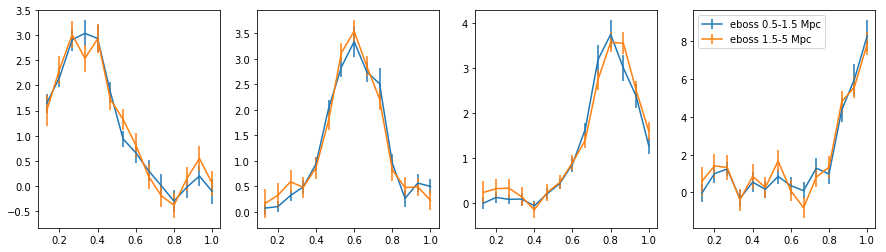

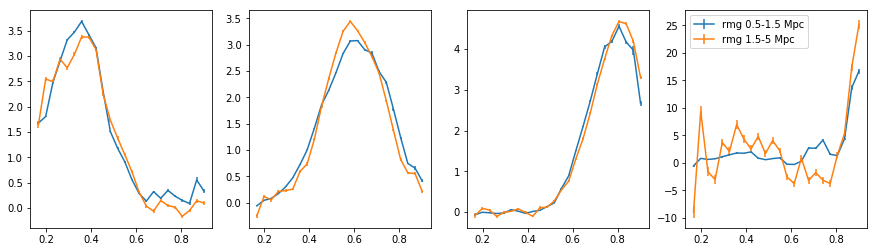

In [96]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_sims['eboss_w'].z
    #ax[i].errorbar(z, runs_data['eboss_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_sims['eboss_w'].Nz['wdm_br'][i,:,0], runs_sims['eboss_w'].Nz_err['wdm_br'][i,:], label='eboss 0.5-1.5 Mpc')         
    ax[i].errorbar(z, runs_sims['eboss_w_1500_5000'].Nz['wdm_br'][i,:,0], runs_sims['eboss_w_1500_5000'].Nz_err['wdm_br'][i,:], label='eboss 1.5-5 Mpc')         
plt.suptitle('Nz data eboss - small vs large scales')
plt.legend(loc = 2)
plt.savefig('./nz_data_eboss_small_large.pdf',bbox_inches='tight')

fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_sims['rmgz'].z
    #ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_sims['rmgz'].Nz['wdm_br'][i,:,0], runs_sims['rmgz'].Nz_err['wdm_br'][i,:], label='rmg 0.5-1.5 Mpc')         
    ax[i].errorbar(z, runs_sims['rmgz_1500_5000kpc'].Nz['wdm_br'][i,:,0], runs_sims['rmgz_1500_5000kpc'].Nz_err['wdm_br'][i,:], label='rmg 1.5-5 Mpc')         

plt.legend()

## comparison rm vs eboss

In [73]:
# load theory
bias_correction = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/bias_corr')
data_cosmosis = load_obj('/global/cscratch1/sd/mgatti/clustering_z/data/dict_cosmosis')

import sys
sys.path.insert(0, '/global/homes/g/giannini/clustering-z/WZ_utils/')
from covariance_routines import *
from load_routines import *



path_base = '/global/cscratch1/sd/mgatti/clustering_z/mastercat_12_3_19_'



measured_wz = load_obj('/global/homes/m/mgatti/clustering-z/WZ_cosmosis1')

runs_data_comp = dict()


n_jck=100
gamma = 1
zmin=0.1
zmax=1.1
bins = 15
ang_bins = 8

info ={'n_jck':n_jck,'zmin':zmin,'zmax':zmax,'bins' : bins}
     
to_read = [
    'eboss/',
'eboss_R/',
'eboss_R_w/',
'eboss_R_w_1500_5000/',
'eboss_R_w_25_rm/',
'eboss_w/']

        
for ff in to_read:
    try:
        dictionary = read_results_fast(path_base+ff,n_jck,gamma,ang_bins)
        method = ff.strip('/')
        print (method)
        runs_data_comp[method]  = WZ_obj(dictionary,info)
        if '1500_5000' in method:
            runs_data_comp[method].set_wdm(data_cosmosis['sims_WL_eboss_large']['w_rr'][0,:])
        else:
            runs_data_comp[method].set_wdm(data_cosmosis['sims_WL_eboss']['w_rr'][0,:])
        runs_data_comp[method].set_sompz(nz_sompz_15bins)
        runs_data_comp[method].shrink_z_interval(xd=0,xup=2)
        runs_data_comp[method].compute_Xsigma_sompz(nz_sompz_15bins)
        runs_data_comp[method].compute_nz(estimators = ['y1','wdm_br','wdm'])
        #runs_data[method].compute_nz(estimators = ['y1','wdm_br','wdm','wdm_brcorr'])
        runs_data_comp[method].compute_mean_std()
    except:
        print (path_base+ff), 'failed'

print ('done')
# '''
# to print the mean:
# runs[method].Nz_mean[estimator][tomobin],runs[method].Nz_mean_err[estimator][tomobin]

# '''

eboss
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R_w
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R_w_1500_5000
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_R_w_25_rm
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
eboss_w
shrinking: nothing to do for b_corr
computing sompz interval at 2 sigma
done


In [331]:
runs_data['rmg_R_w'].sompz[i].shape

(24,)

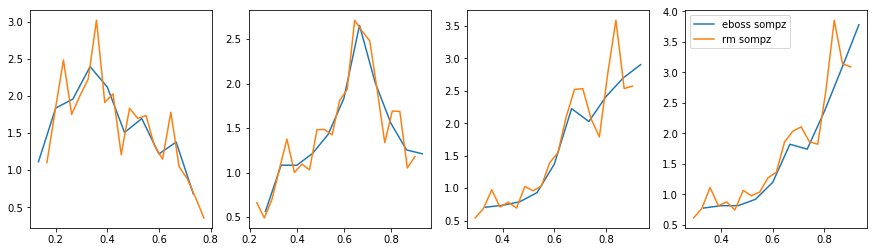

In [74]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    mask_sompz = runs_data_comp['eboss_R_w'].maskXsigma
    z = runs_data_comp['eboss_R_w'].z[mask_sompz[i]]
    #print z
    ax[i].errorbar(z, runs_data_comp['eboss_R_w'].sompz[i][mask_sompz[i]], label='eboss sompz')         
    mask_sompz = runs_data['rmg_R_w'].maskXsigma
    z = runs_data['rmg_R_w'].z[mask_sompz[i]]
    #print z
    ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i][mask_sompz[i]], label='rm sompz')         
plt.legend()

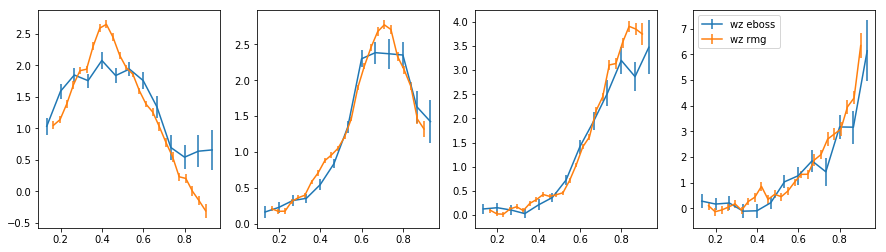

In [75]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data_comp['eboss_R_w'].z
    #ax[i].errorbar(z, runs_data['eboss_R_w'].sompz[i], label='sompz')         
    ax[i].errorbar(z, runs_data_comp['eboss_R_w'].Nz['wdm_br'][i,:,0], runs_data_comp['eboss_R_w'].Nz_err['wdm_br'][i,:], label='wz eboss')         
    z = runs_data['rmg_R_w'].z
    ax[i].errorbar(z, runs_data['rmg_R_w'].Nz['wdm_br'][i,:,0], runs_data['rmg_R_w'].Nz_err['wdm_br'][i,:], label='wz rmg')         
plt.legend()

In [345]:
runs_data['eboss_R_w'].Nz['y1'].shape

(4, 14, 101)

In [76]:
for i in range(4):
    print '\n'
    print 'BIN ', i 
    for est in runs_data_comp['eboss'].Nz.keys():
        print '------'
        print est
        print '------'

        for method in runs_data_comp.keys():
            
            print method
            print '-'
            print 'shift        {0:2.3f}'.format(runs_data_comp[method].sompz_mean[est][i]-runs_data_comp[method].Nz_mean[est][i])
            print 'shifterr     {0:2.4f}'.format(2*runs_data_comp[method].Nz_mean_err[est][i])
            print 'mean         {0:2.3f}'.format(runs_data_comp[method].Nz_mean[est][i])
            print 'meanerr      {0:2.4f}'.format(runs_data_comp[method].Nz_mean_err[est][i])
            print 'std          {0:2.3f}'.format(runs_data_comp[method].Nz_std[est][i])
            print 'stderr       {0:2.3f}'.format(runs_data_comp[method].Nz_std_err[est][i])
            print 




BIN  0
------
y1
------
eboss_R_w_1500_5000
-
shift        -0.003
shifterr     0.0174
mean         0.407
meanerr      0.0087
std          0.182
stderr       0.012

eboss_w
-
shift        0.014
shifterr     0.0083
mean         0.391
meanerr      0.0041
std          0.186
stderr       0.005

eboss_R
-
shift        0.008
shifterr     0.0092
mean         0.397
meanerr      0.0046
std          0.187
stderr       0.006

eboss_R_w
-
shift        0.009
shifterr     0.0093
mean         0.395
meanerr      0.0047
std          0.182
stderr       0.006

eboss
-
shift        0.010
shifterr     0.0084
mean         0.395
meanerr      0.0042
std          0.185
stderr       0.006

eboss_R_w_25_rm
-
shift        -0.048
shifterr     0.0123
mean         0.453
meanerr      0.0061
std          0.234
stderr       0.003

------
wdm_br
------
eboss_R_w_1500_5000
-
shift        -0.012
shifterr     0.0197
mean         0.417
meanerr      0.0098
std          0.195
stderr       0.014

eboss_w
-
shift        -0.012

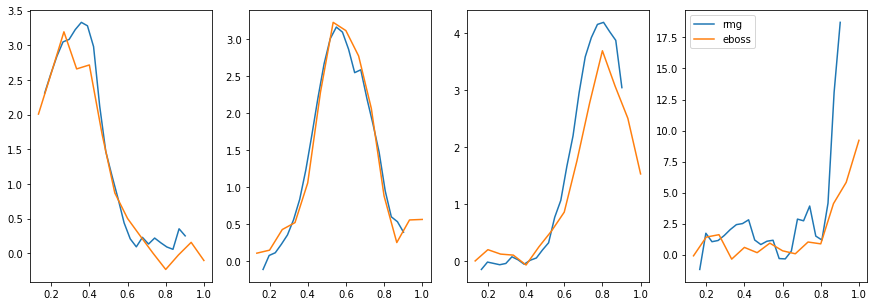

In [97]:
fig, ax = plt.subplots(1, 4, figsize = (15,5))
for t in range(4):
    for est in ['y1']:
        ax[t].plot(runs_sims['rmgz'].z, runs_sims['rmgz'].Nz[est][t, :, 0], label = 'rmg')
        ax[t].plot(runs_sims['eboss_w'].z, runs_sims['eboss_w'].Nz[est][t, :, 0], label = 'eboss')
plt.legend()

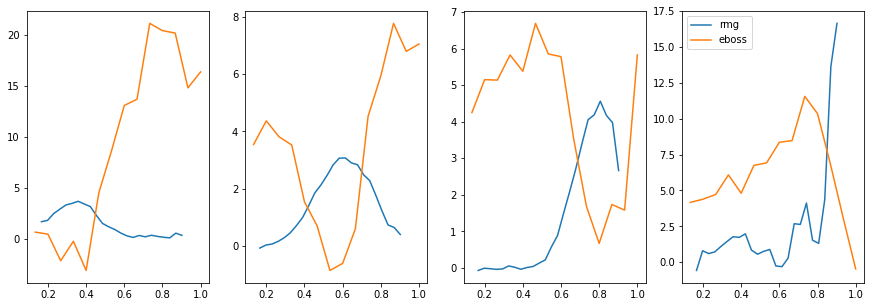

In [98]:
fig, ax = plt.subplots(1, 4, figsize = (15,5))
for t in range(4):
    for est in ['wdm_br']:
        ax[t].plot(runs_sims['rmgz_1500_5000kpc'].z, runs_sims['rmgz'].Nz[est][t, :, 0], label = 'rmg')
        ax[t].plot(runs_sims['eboss_1500_5000kpc'].z, runs_sims['eboss'].Nz[est][t, :, 0], label = 'eboss')
plt.legend()

In [1]:
'''
x redamagic *************************
systematics [ type_sims] [ tomo bin] [estimator] [key]
type_sims =0 -> spec z ref
type_sims =1 -> rmg z ref

estimator:
'bias_wl', 'bias_wl_full', 'w_br', 'w_br_bl', 'true'

x eboss **************************
systematics_eboss [ type_sims] [ tomo bin] [estimator]  [key]
type_sims =0 -> spec z ref default

estimator:
'bias_wl', 'bias_wl_full', 'w_br', 'w_br_bl', 'true'

'''

"\nx redamagic *************************\nsystematics [ type_sims] [ tomo bin] [estimator] [key]\ntype_sims =0 -> spec z ref\ntype_sims =1 -> rmg z ref\n\nestimator:\n'bias_wl', 'bias_wl_full', 'w_br', 'w_br_bl', 'true'\n\nx eboss **************************\nsystematics_eboss [ type_sims] [ tomo bin] [estimator]  [key]\ntype_sims =0 -> spec z ref default\n\nestimator:\n'bias_wl', 'bias_wl_full', 'w_br', 'w_br_bl', 'true'\n\n"

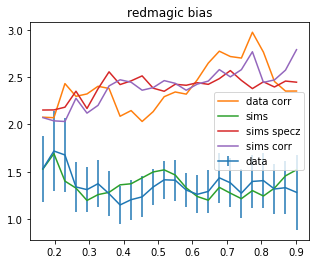

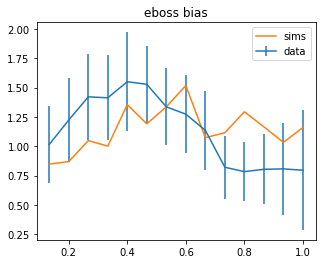

In [323]:
fig, ax = plt.subplots(figsize=(5,4))

intt = np.trapz(np.sqrt(runs[0]['bz'][0,:24,0]/measured_wz['th_correction']), x = zbins_c[:24])
ntt = np.trapz(measured_wz['bias_rm'][0][:,0], x = zbins_c[:24])
plt.errorbar(zbins_c[:24], np.sqrt(runs[0]['bz'][0,:24,0]/measured_wz['th_correction'])/intt, np.sqrt(cov_bias_rm[0][0]['err']/measured_wz['th_correction'])/intt, label = 'data')
plt.plot(zbins_c[:24], np.sqrt(runs[0]['bz'][0,:24,0]/measured_wz['th_correction'])/intt/corr_sims[:24], label = 'data corr')

plt.plot(zbins_c[:24], measured_wz['bias_rm'][0][:,0]/ntt, label = 'sims')
plt.plot(zbins_c[:24], measured_wz['bias_rm_specz'][0][:,0]/ntt, label = 'sims specz')
plt.plot(zbins_c[:24], measured_wz['bias_rm'][0][:,0]/corr_sims[:24]/ntt, label = 'sims corr')






#plt.suptitle('small vs large scales')
plt.title('redmagic bias')
plt.legend()



fig, ax = plt.subplots( figsize=(5,4))



intt = np.trapz(np.sqrt(runs_eboss[0]['bz'][0,:14,0]/measured_wz['th_correction_eboss']), x = zbinse_c[:14])
ntt = np.trapz(measured_wz['bias_eboss'][0][:,0], x = zbinse_c[:14])
plt.errorbar(zbinse_c[:14], np.sqrt(runs_eboss[0]['bz'][0,:14,0]/measured_wz['th_correction_eboss'])/intt, np.sqrt(cov_bias_eboss[0][0]['err']/measured_wz['th_correction_eboss'])/intt, label = 'data')
plt.plot(zbinse_c[:14], measured_wz['bias_eboss'][0][:,0]/ntt, label = 'sims')
#plt.suptitle('small vs large scales')
plt.title('eboss bias')
plt.legend()

# COMPARISON DATA SIMS

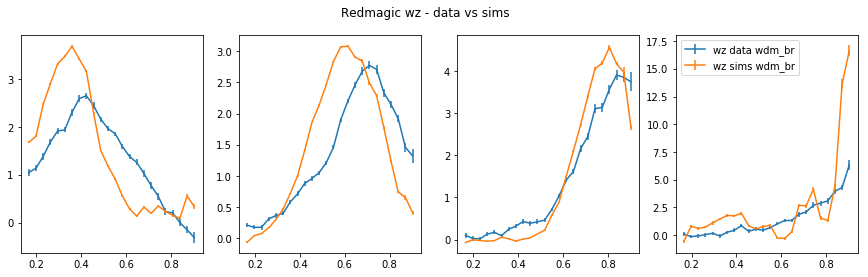

In [100]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['rmg_R_w'].z
    #ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
    #for est in runs_data['rmg_R_w'].Nz_mean.keys():
    est = 'wdm_br'
    ax[i].errorbar(z, runs_data['rmg_R_w'].Nz[est][i,:,0], runs_data['rmg_R_w'].Nz_err[est][i,:], label='wz data {0}'.format(est))         

    z = runs_sims['rmgz'].z
    #ax[i].errorbar(z, runs_sims['rmgz'].sompz[i], label='sompz')         
    #for est in runs_sims['rmgz'].Nz_mean.keys():
    est = 'wdm_br'
    ax[i].errorbar(z, runs_sims['rmgz'].Nz[est][i,:,0], runs_sims['rmgz'].Nz_err[est][i,:], label='wz sims {0}'.format(est))         
plt.suptitle('Redmagic wz - data vs sims')
plt.legend()

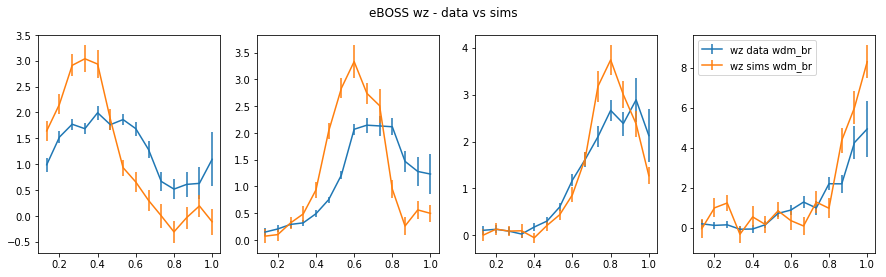

In [101]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i in range(4):
    z = runs_data['eboss_R_w'].z
    #ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
    #for est in runs_data['rmg_R_w'].Nz_mean.keys():
    est = 'wdm_br'
    ax[i].errorbar(z, runs_data['eboss_R_w'].Nz[est][i,:,0], runs_data['eboss_R_w'].Nz_err[est][i,:], label='wz data {0}'.format(est))         

    z = runs_sims['eboss_w'].z
    #ax[i].errorbar(z, runs_sims['rmgz'].sompz[i], label='sompz')         
    #for est in runs_sims['rmgz'].Nz_mean.keys():
    est = 'wdm_br'
    ax[i].errorbar(z, runs_sims['eboss_w'].Nz[est][i,:,0], runs_sims['eboss_w'].Nz_err[est][i,:], label='wz sims {0}'.format(est))         
plt.suptitle('eBOSS wz - data vs sims')
plt.legend()

In [110]:
runs_data['eboss_R_w'].w_rr.shape

(4, 15, 101)

In [116]:
len(runs_data['eboss_R_w'].z)

14

In [117]:
len(runs_data['eboss_R_w'].w_rr[0, :,0])

15

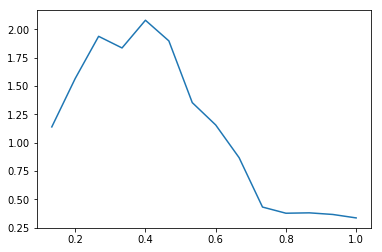

In [118]:
plt.plot(runs_data['eboss_R_w'].z, runs_data['eboss_R_w'].w_rr[0, :14,0])

In [164]:
runs_data['rmg_R_w'].bz['y1'][:,:,0]

array([[1.87729492, 2.121534  , 2.05366426, 1.58435639, 1.59995555,
        1.67780677, 1.52064229, 1.38815497, 1.46185775, 1.49028537,
        1.61209623, 1.69462245, 1.69560505, 1.58738851, 1.50697002,
        1.53416065, 1.74657116, 1.68478877, 1.51293679, 1.67591113,
        1.71653065, 1.59006543, 1.59482266, 1.54805992],
       [1.74203545, 1.96867706, 1.90569734, 1.4702032 , 1.48467843,
        1.55692046, 1.41107971, 1.28813813, 1.35653061, 1.38291001,
        1.49594437, 1.57252456, 1.57343636, 1.47301685, 1.39839253,
        1.42362407, 1.62073036, 1.56339941, 1.40392939, 1.5551614 ,
        1.59285427, 1.4755009 , 1.47991537, 1.4365219 ],
       [1.9383787 , 2.19056488, 2.12048678, 1.63590848, 1.65201521,
        1.73239956, 1.57012124, 1.43332302, 1.50942395, 1.53877656,
        1.66455092, 1.7497624 , 1.75077697, 1.63903926, 1.5560041 ,
        1.58407946, 1.80340142, 1.73960875, 1.56216501, 1.73044225,
        1.77238345, 1.64180328, 1.6467153 , 1.59843099],
       [1.938

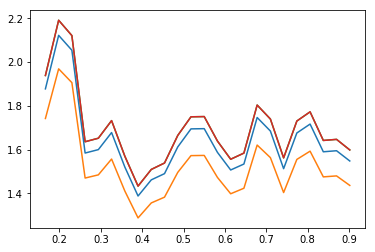

In [170]:
z = runs_data['rmg_R_w'].z
#ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
#for est in runs_data['rmg_R_w'].Nz_mean.keys():
for i in range(4):   
    est = 'wdm_br'
    plt.errorbar(z, runs_data['rmg_R_w'].bz['y1'][i,:,0], label='wz data {0}'.format(i))      


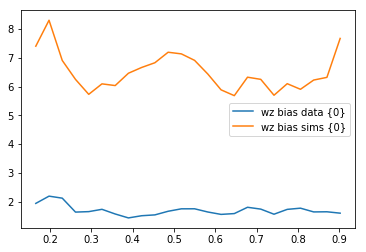

In [28]:
z = runs_data['rmg_R_w'].z
#ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
#for est in runs_data['rmg_R_w'].Nz_mean.keys():  
est = 'wdm_br'
plt.errorbar(z, runs_data['rmg_R_w'].bz[est][3,:,0], label='wz bias data {0}')      
z = runs_sims['rmgz'].z
plt.errorbar(z, runs_sims['rmgz'].bz[est][3,:,0], label='wz bias sims {0}')         

plt.legend()

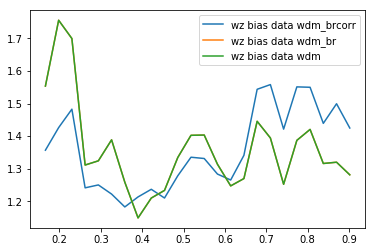

In [36]:
z = runs_data['rmg_R_w'].z
#ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
#for est in runs_data['rmg_R_w'].Nz_mean.keys():  
plt.errorbar(z, runs_data['rmg_R_w'].bz['wdm_brcorr'][3,:,0]/np.trapz(runs_data['rmg_R_w'].bz['wdm_brcorr'][3,:,0], x = z), label='wz bias data wdm_brcorr')      
plt.errorbar(z, runs_data['rmg_R_w'].bz['wdm_br'][3,:,0]/np.trapz(runs_data['rmg_R_w'].bz['wdm_br'][3,:,0], x = z), label='wz bias data wdm_br')      
plt.errorbar(z, runs_data['rmg_R_w'].bz['wdm'][3,:,0]/np.trapz(runs_data['rmg_R_w'].bz['wdm'][3,:,0], x = z), label='wz bias data wdm')      

plt.legend()

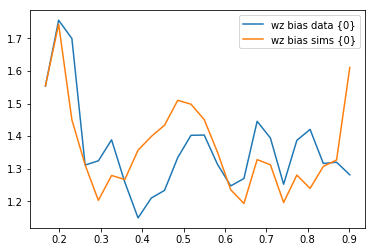

In [34]:
z = runs_data['rmg_R_w'].z
#ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
#for est in runs_data['rmg_R_w'].Nz_mean.keys():  
est = 'wdm_br'
plt.errorbar(z, runs_data['rmg_R_w'].bz[est][3,:,0]/np.trapz(runs_data['rmg_R_w'].bz[est][3,:,0], x = z), label='wz bias data {0}')      
z = runs_sims['rmgz'].z
plt.errorbar(z, runs_sims['rmgz'].bz[est][3,:,0]/np.trapz(runs_sims['rmgz'].bz[est][3,:,0], x = z), label='wz bias sims {0}')         

plt.legend()

In [211]:
runs_data['rmg_R_w'].bz_err[est][3,:]

array([0.04221196, 0.05189789, 0.04892987, 0.03016462, 0.0255841 ,
       0.02479992, 0.02481509, 0.02254258, 0.02335505, 0.02281161,
       0.01626307, 0.01665451, 0.01867741, 0.01521755, 0.01923836,
       0.02574563, 0.03173509, 0.03346951, 0.03555426, 0.03737622,
       0.03937223, 0.03511605, 0.03994557, 0.08285589])

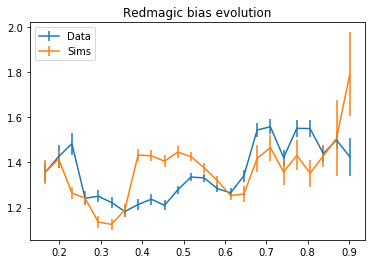

In [229]:
z = runs_data['rmg_R_w'].z
#ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
#for est in runs_data['rmg_R_w'].Nz_mean.keys():  
est = 'wdm_brcorr'
plt.errorbar(z, (runs_data['rmg_R_w'].bz[est][3,:,0]/np.trapz(runs_data['rmg_R_w'].bz[est][3,:,0], x = z)), yerr = (runs_data['rmg_R_w'].bz_err[est][3,:]), label='Data')      
#plt.errorbar(z, (runs_data['rmg_R_w'].bz[est][3,:,0]/np.trapz(runs_data['rmg_R_w'].bz[est][3,:,0], x = z)), yerr = (runs_data['rmg_R_w'].bz_err[est][3,:]/np.trapz(runs_data['rmg_R_w'].bz_err[est][3,:], x = z)), label='Data')      
z = runs_sims['rmgz'].z
plt.errorbar(z, runs_sims['rmgz'].bz[est][3,:,0]/np.trapz(runs_sims['rmgz'].bz[est][3,:,0], x = z), runs_sims['rmgz'].bz_err[est][3,:], label='Sims')         
plt.title('Redmagic bias evolution')
plt.legend(loc = 2)
plt.savefig('./rm_bias.pdf')

In [231]:
runs_data.keys()

['rmg_R',
 'rmg_R_w',
 'rmg_w',
 'eboss_R_w_1500_5000',
 'eboss_w',
 'eboss_R',
 'rmg_R_w_1500_5000',
 'eboss_R_w',
 'rmg',
 'eboss',
 'rmg_higher_R',
 'eboss_R_w_25_rm']

In [232]:
runs_sims.keys()

['rmgz_1500_5000kpc',
 'rmgz_higherlum',
 'eboss_w',
 'truez_higherlum',
 'truez',
 'rmgz',
 'truez_1500_5000kpc',
 'eboss_w_1500_5000']

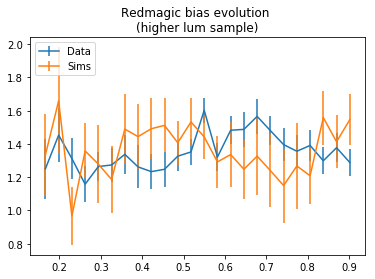

In [235]:
z = runs_data['rmg_R_w'].z
#ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
#for est in runs_data['rmg_R_w'].Nz_mean.keys():  
est = 'wdm_brcorr'
plt.errorbar(z, (runs_data['rmg_higher_R'].bz[est][3,:,0]/np.trapz(runs_data['rmg_higher_R'].bz[est][3,:,0], x = z)), yerr = (runs_data['rmg_higher_R'].bz_err[est][3,:]), label='Data')      
#plt.errorbar(z, (runs_data['rmg_R_w'].bz[est][3,:,0]/np.trapz(runs_data['rmg_R_w'].bz[est][3,:,0], x = z)), yerr = (runs_data['rmg_R_w'].bz_err[est][3,:]/np.trapz(runs_data['rmg_R_w'].bz_err[est][3,:], x = z)), label='Data')      
z = runs_sims['rmgz'].z
plt.errorbar(z, runs_sims['rmgz_higherlum'].bz[est][3,:,0]/np.trapz(runs_sims['rmgz_higherlum'].bz[est][3,:,0], x = z), runs_sims['rmgz_higherlum'].bz_err[est][3,:], label='Sims')         
plt.title('Redmagic bias evolution \n(higher lum sample)')
plt.legend(loc = 2)
plt.savefig('./rm_bias_higher_corr.pdf')

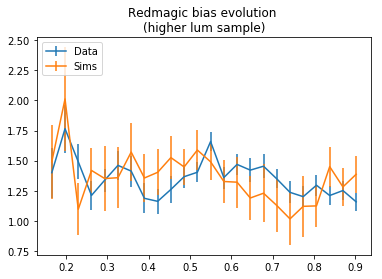

In [236]:
z = runs_data['rmg_R_w'].z
#ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
#for est in runs_data['rmg_R_w'].Nz_mean.keys():  
est = 'wdm_br'
plt.errorbar(z, (runs_data['rmg_higher_R'].bz[est][3,:,0]/np.trapz(runs_data['rmg_higher_R'].bz[est][3,:,0], x = z)), yerr = (runs_data['rmg_higher_R'].bz_err[est][3,:]), label='Data')      
#plt.errorbar(z, (runs_data['rmg_R_w'].bz[est][3,:,0]/np.trapz(runs_data['rmg_R_w'].bz[est][3,:,0], x = z)), yerr = (runs_data['rmg_R_w'].bz_err[est][3,:]/np.trapz(runs_data['rmg_R_w'].bz_err[est][3,:], x = z)), label='Data')      
z = runs_sims['rmgz'].z
plt.errorbar(z, runs_sims['rmgz_higherlum'].bz[est][3,:,0]/np.trapz(runs_sims['rmgz_higherlum'].bz[est][3,:,0], x = z), runs_sims['rmgz_higherlum'].bz_err[est][3,:], label='Sims')         
plt.title('Redmagic bias evolution \n(higher lum sample)')
plt.legend(loc = 2)
plt.savefig('./rm_bias_higher.pdf')

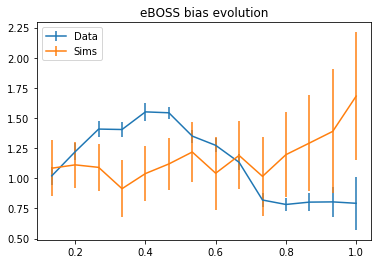

In [230]:
z = runs_data['eboss_R_w'].z
#ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
#for est in runs_data['rmg_R_w'].Nz_mean.keys():  
est = 'wdm_br'
plt.errorbar(z, (runs_data['eboss_R_w'].bz[est][3,:,0]/np.trapz(runs_data['eboss_R_w'].bz[est][3,:,0], x = z)), yerr = (runs_data['eboss_R_w'].bz_err[est][3,:]), label='Data')      
#plt.errorbar(z, (runs_data['rmg_R_w'].bz[est][3,:,0]/np.trapz(runs_data['rmg_R_w'].bz[est][3,:,0], x = z)), yerr = (runs_data['rmg_R_w'].bz_err[est][3,:]/np.trapz(runs_data['rmg_R_w'].bz_err[est][3,:], x = z)), label='Data')      
z = runs_sims['eboss_w'].z
plt.errorbar(z, runs_sims['eboss_w'].bz[est][3,:,0]/np.trapz(runs_sims['eboss_w'].bz[est][3,:,0], x = z), runs_sims['eboss_w'].bz_err[est][3,:], label='Sims')         
plt.title('eBOSS bias evolution')
plt.legend(loc = 2)
plt.savefig('./eboss_bias.pdf')

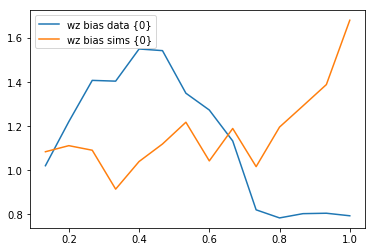

In [31]:
z = runs_data['eboss_R_w'].z
#ax[i].errorbar(z, runs_data['rmg_R_w'].sompz[i], label='sompz')         
#for est in runs_data['rmg_R_w'].Nz_mean.keys():  
est = 'wdm_br'
plt.errorbar(z, runs_data['eboss_R_w'].bz[est][3,:,0]/np.trapz(runs_data['eboss_R_w'].bz[est][3,:,0], x = z), label='wz bias data {0}')      
z = runs_sims['eboss_w'].z
plt.errorbar(z, runs_sims['eboss_w'].bz[est][3,:,0]/np.trapz(runs_sims['eboss_w'].bz[est][3,:,0], x = z), label='wz bias sims {0}')         

plt.legend()

In [37]:
mastercat.keys()

[u'catalog', u'index', u'maps', u'masks', u'randoms', u'regions']

In [42]:
mastercat['catalog/redmagic/higherlum'].keys()

[u'chisq',
 u'coadd_object_id',
 u'dec',
 u'mabs',
 u'mabs_err',
 u'model_mag',
 u'model_magerr',
 u'ra',
 u'redmagicflag',
 u'zlum',
 u'zmag',
 u'zmag_err',
 u'zredmagic',
 u'zredmagic_e',
 u'zspec']

In [45]:
zspec = np.array(mastercat['catalog/redmagic/higherlum/zspec'])
zredmagic = np.array(mastercat['catalog/redmagic/higherlum/zredmagic'])

In [50]:
len(zspec-zredmagic), len(zspec)

(528288, 528288)

In [57]:
specz_bins = np.histogram(zspec, 100)

In [71]:
runs_sims.keys()

['rmgz_1500_5000kpc',
 'rmgz_higherlum',
 'eboss_w',
 'truez_higherlum',
 'truez',
 'rmgz',
 'truez_1500_5000kpc',
 'eboss_w_1500_5000']

In [72]:
for i in range(4):
    print '\n'
    print 'BIN ', i 
    for est in runs_sims['rmgz'].Nz.keys():
        print '------'
        print est
        print '------'

        for method in ['rmgz']: #runs_sims.keys():
            try: 

                print method
                print '-'
                print 'shift sims       {0:2.3f}'.format(runs_sims[method].sompz_mean[est][i]-runs_sims[method].Nz_mean[est][i])
#                 print 'shifterr     {0:2.4f}'.format(2*runs_sims[method].Nz_mean_err[est][i])
#                 print 'mean         {0:2.3f}'.format(runs_sims[method].Nz_mean[est][i])
#                 print 'meanerr      {0:2.4f}'.format(runs_sims[method].Nz_mean_err[est][i])
#                 print 'std          {0:2.3f}'.format(runs_sims[method].Nz_std[est][i])
#                 print 'stderr       {0:2.3f}'.format(runs_sims[method].Nz_std_err[est][i])
            except: 
                print 'eboss does not have {0} estimator'.format(est)
                continue
        for method in ['rmg_R_w']: #runs_data.keys():
            try: 

                print method
                print '-'
                print 'shift data        {0:2.3f}'.format(runs_data[method].sompz_mean[est][i]-runs_data[method].Nz_mean[est][i])
#                 print 'shifterr     {0:2.4f}'.format(2*runs_sims[method].Nz_mean_err[est][i])
#                 print 'mean         {0:2.3f}'.format(runs_sims[method].Nz_mean[est][i])
#                 print 'meanerr      {0:2.4f}'.format(runs_sims[method].Nz_mean_err[est][i])
#                 print 'std          {0:2.3f}'.format(runs_sims[method].Nz_std[est][i])
#                 print 'stderr       {0:2.3f}'.format(runs_sims[method].Nz_std_err[est][i])
            except: 
                print 'eboss does not have {0} estimator'.format(est)
                continue



BIN  0
------
y1
------
rmgz
-
shift sims       0.021
rmg_R_w
-
shift data        0.013
------
wdm_brcorr
------
rmgz
-
shift sims       0.019
rmg_R_w
-
shift data        0.003
------
wdm_br
------
rmgz
-
shift sims       0.010
rmg_R_w
-
shift data        -0.013
------
wdm
------
rmgz
-
shift sims       0.011
rmg_R_w
-
shift data        -0.007


BIN  1
------
y1
------
rmgz
-
shift sims       0.019
rmg_R_w
-
shift data        -0.028
------
wdm_brcorr
------
rmgz
-
shift sims       0.013
rmg_R_w
-
shift data        -0.029
------
wdm_br
------
rmgz
-
shift sims       0.002
rmg_R_w
-
shift data        -0.047
------
wdm
------
rmgz
-
shift sims       0.008
rmg_R_w
-
shift data        -0.048


BIN  2
------
y1
------
rmgz
-
shift sims       0.011
rmg_R_w
-
shift data        -0.047
------
wdm_brcorr
------
rmgz
-
shift sims       0.012
rmg_R_w
-
shift data        -0.049
------
wdm_br
------
rmgz
-
shift sims       0.009
rmg_R_w
-
shift data        -0.060
------
wdm
------
rmgz
-
shift sims

In [253]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
c_2=rgb_to_hex((239, 96, 96))
c_3=rgb_to_hex((255, 194, 0))
c_23=rgb_to_hex((121, 183, 179))
def plot_1d(array, array_err, truth_id, ax, label, legend=0,color=c_2,lab=''):
    print array
    ax.plot([truth[truth_id], truth[truth_id]], [-1,13], color='grey', ls='--', lw=1)
    ax.set_ylim(-1,len(array))
    #ax.scatter(array, np.arange(len(array)), marker='o', color=color,label=lab)
    ax.errorbar(array, np.arange(len(array)), xerr = array_err, marker='o', linewidth = 0, elinewidth = 1, color=color,label=lab)
    ax.set_yticks([-10.0])
    ax.set_yticklabels([''])
    ax.set_xlabel(label,size=13)
    




# plot x paper

[-0.002689367080303262]
[0.007457343596258159]
[0.03011579673520548]
[0.000554506471868832]
[0.04381688998879929]
[-0.013201497068575763]
[0.00235395753102563]
[0.0007335268800734429]


Text(0.45,-0.2,'y1')

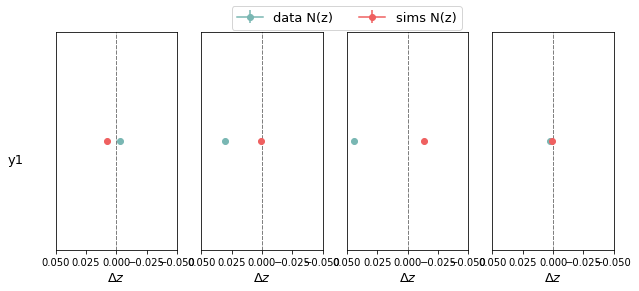

In [167]:
labb = np.array(np.sort(runs_data.keys()))
# r'$w_{\rm ur}/w_{\rm DM}$',
# r'$w_{\rm ur}/w_{\rm DM}$ C',
# #r'$w_{\rm ur}/w_{\rm DM}$ rC data',
# r'$w_{\rm ur}/w_{\rm DM}$ C nocorr',
# #r'$w_{\rm ur}/w_{\rm DM}$ rC data nocorr',
# r'$w_{\rm ur}/w_{\rm DM}$ L',
# #r'$w_{\rm ur}/w_{\rm DM}$ rL data',
# r'$w_{\rm ur}/w_{\rm DM}$ L nocorr',
# #r'$w_{\rm ur}/w_{\rm DM}$ rL data nocorr',
# ])
# array_sims=[]
# for key in wl_sims_nz.keys():
# array_sims.append(np.array([
# shifts_collection[key]['simsw_ur'],
# shifts_collection[key]['simsw_ur/w_dm'],
# shifts_collection[key]['simsw_ur_combined /w_dm'],
# #shifts_collection[key]['simsw_ur_combined_data /w_dm'],
# shifts_collection[key]['simsw_ur_combined /w_dm rmg'],
# #shifts_collection[key]['simsw_ur_combined_data /w_dm rmg'],
# shifts_collection[key]['simsw_ur_higherlum /w_dm'],
# #shifts_collection[key]['simsw_ur_higherlum_data /w_dm'],
# shifts_collection[key]['simsw_ur_higherlum /w_dm rmg'],
# #shifts_collection[key]['simsw_ur_higherlum_data /w_dm rmg'],
# ]))

keyz = ['y1']#, 'wdm_brcorr', 'wdm_br', 'wdm']
dict_data = dict()
est = 'wdm_br'
for i in range(4):
    array_data=[]
    for est in keyz: #np.sort(runs_data.keys())
        if est == 'wdm_brcorr':
            dz_eboss = runs_data['eboss_R_w'].sompz_mean['wdm_br'][i]-runs_data['eboss_R_w'].Nz_mean['wdm_br'][i]
            dz_rm = runs_data['rmg_R_w'].sompz_mean[est][i]-runs_data['rmg_R_w'].Nz_mean[est][i]
            array_data.append(dz_eboss-dz_rm)
        else:
            dz_eboss = runs_data['eboss_R_w'].sompz_mean[est][i]-runs_data['eboss_R_w'].Nz_mean[est][i]
            dz_rm = runs_data['rmg_R_w'].sompz_mean[est][i]-runs_data['rmg_R_w'].Nz_mean[est][i]
            array_data.append(dz_eboss-dz_rm)
    dict_data[i] = array_data
        
        
dict_sims = dict()
est = 'wdm_brcorr'
for i in range(4):
    array_sims=[]
    for est in keyz: #np.sort(runs_sims.keys()):
        if est == 'wdm_brcorr':
            dz_eboss = runs_sims['eboss_w'].sompz_mean['wdm_br'][i]-runs_sims['eboss_w'].Nz_mean['wdm_br'][i]
            dz_rm = runs_sims['rmgz'].sompz_mean[est][i]-runs_sims['rmgz'].Nz_mean[est][i]
            
            array_sims.append(dz_eboss-dz_rm)
        else:
            dz_eboss = runs_sims['eboss_w'].sompz_mean[est][i]-runs_sims['eboss_w'].Nz_mean[est][i]
            dz_rm = runs_sims['rmgz'].sompz_mean[est][i]-runs_sims['rmgz'].Nz_mean[est][i]
            
            array_sims.append(dz_eboss-dz_rm)
    dict_sims[i] = array_sims
     
# shifts_collection[key]['dataw_ur'],
# shifts_collection[key]['dataw_ur/w_dm'],
# shifts_collection[key]['dataw_ur_combined /w_dm'],
# #shifts_collection[key]['dataw_ur_combined_data /w_dm'],
# shifts_collection[key]['dataw_ur_combined /w_dm rmg'],
# #shifts_collection[key]['dataw_ur_combined_data /w_dm rmg'],
# shifts_collection[key]['dataw_ur_higherlum /w_dm'],
# #shifts_collection[key]['dataw_ur_higherlum_data /w_dm'],
# shifts_collection[key]['dataw_ur_higherlum /w_dm rmg'],
# #shifts_collection[key]['dataw_ur_higherlum_data /w_dm rmg'],
# ]))
xmin=-0.05
xmax=-0.05
truth = np.zeros(4)
plt.figure(figsize=(10,4))
ax0 = plt.subplot(141)
plot_1d(dict_data[0], 0, ax0, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
plot_1d(dict_sims[0], 0, ax0, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
ax1 = plt.subplot(142)
plot_1d(dict_data[1], 1, ax1, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
plot_1d(dict_sims[1], 1, ax1, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
ax2 = plt.subplot(143)
plot_1d(dict_data[2], 2, ax2, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
plot_1d(dict_sims[2], 2, ax2, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
ax3 = plt.subplot(144)
plot_1d(dict_data[3], 3, ax3, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
plot_1d(dict_sims[3], 3, ax3, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
plt.legend(bbox_to_anchor=(-0.2,1.15),ncol = 3, fontsize=13)
uu = 0.45
# #plt.text(uu,11.8,"Scale cut", fontsize=13)
# #plt.text(uu,10.8,r"$12 h^{-1}$ Mpc", fontsize=13)
#plt.text(uu,0.8 ,'ciao', fontsize=13)
# #plt.text(uu,8.8 ,labb[9], fontsize=13)
# #plt.text(uu,7.8 ,labb[8], fontsize=13)
# #plt.text(uu,6.8 ,labb[7], fontsize=13)
# #plt.text(uu,5.8 ,labb[6], fontsize=13)
# plt.text(uu,4.8 ,labb[5], fontsize=13)
# plt.text(uu,3.8 ,labb[4], fontsize=13)
#plt.text(uu,2.8 ,keyz[3], fontsize=13)
#plt.text(uu,1.8 ,keyz[2], fontsize=13)
#plt.text(uu,0.8 ,keyz[1], fontsize=13)
plt.text(uu,-0.2,keyz[0], fontsize=13)
# plt.tight_layout()
# plt.legend(bbox_to_anchor=(-0.2,1.15),ncol = 3, fontsize=13)
# #plt.savefig('./figures_x_paper/mean_shifts_cosmosis.pdf',bbox_inches='tight')





In [160]:
#small vs large

[0.00334141 0.01254457]
[0.00621277 0.00023456]
[-0.01101874  0.00321254]
[ 0.00160384 -0.00663186]
[ 0.0044504  -0.01176185]
[0.01053028 0.00795565]
[-0.01530368 -0.03664634]
[-0.00544026  0.03919368]


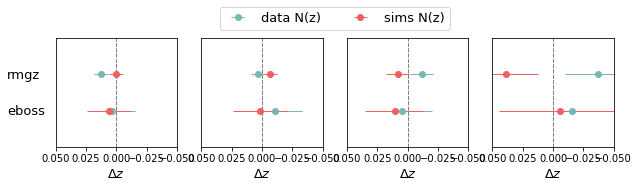

In [195]:
# dz_eboss = runs_data['eboss_R_w'].sompz_mean['wdm_br'][i]-runs_data['eboss_R_w'].Nz_mean['wdm_br'][i]
# dz_rm = runs_data['rmg_R_w'].sompz_mean[est][i]-runs_data['rmg_R_w'].Nz_mean[est][i]
# array_data.append(dz_eboss-dz_rm)
        
#keyz = ['y1']#, 'wdm_brcorr', 'wdm_br', 'wdm']
keyz = runs_data.keys()#, 'wdm_brcorr', 'wdm_br', 'wdm']
dict_data = dict()
for i in range(4):
    array_data=dict()
    dz_eboss = runs_data['eboss_R_w'].sompz_mean['wdm_br'][i]-runs_data['eboss_R_w'].Nz_mean['wdm_br'][i]
    dz_rm = runs_data['rmg_R_w'].sompz_mean['wdm_brcorr'][i]-runs_data['rmg_R_w'].Nz_mean['wdm_brcorr'][i]
    dz_eboss_l = runs_data['eboss_R_w_1500_5000'].sompz_mean['wdm_br'][i]-runs_data['eboss_R_w_1500_5000'].Nz_mean['wdm_br'][i]
    dz_rm_l = runs_data['rmg_R_w_1500_5000'].sompz_mean['wdm_brcorr'][i]-runs_data['rmg_R_w_1500_5000'].Nz_mean['wdm_brcorr'][i]
    array_data['eboss' ] = dz_eboss-dz_eboss_l
    array_data['rm' ] = dz_rm-dz_rm_l
    array_data['eboss_err' ] =  runs_data['eboss_R_w'].Nz_mean_err['wdm_br'][i]+runs_data['eboss_R_w_1500_5000'].Nz_mean_err['wdm_br'][i]
    array_data['rm_err' ] = runs_data['rmg_R_w'].Nz_mean_err['wdm_brcorr'][i]+runs_data['rmg_R_w_1500_5000'].Nz_mean_err['wdm_brcorr'][i]

    dict_data[i] = array_data
        

dict_sims = dict()
for i in range(4):
    array_sims=dict()
    dz_eboss = runs_sims['eboss_w'].sompz_mean['wdm_br'][i]-runs_sims['eboss_w'].Nz_mean['wdm_br'][i]
    dz_rm = runs_sims['rmgz'].sompz_mean['wdm_brcorr'][i]-runs_sims['rmgz'].Nz_mean['wdm_brcorr'][i]
    dz_eboss_l = runs_sims['eboss_w_1500_5000'].sompz_mean['wdm_br'][i]-runs_sims['eboss_w_1500_5000'].Nz_mean['wdm_br'][i]
    dz_rm_l = runs_sims['rmgz_1500_5000kpc'].sompz_mean['wdm_brcorr'][i]-runs_sims['rmgz_1500_5000kpc'].Nz_mean['wdm_brcorr'][i]
    array_sims['eboss' ] = dz_eboss-dz_eboss_l
    array_sims['rm' ] = dz_rm-dz_rm_l    
    array_sims['eboss_err' ] =  runs_sims['eboss_w'].Nz_mean_err['wdm_br'][i]+runs_sims['eboss_w_1500_5000'].Nz_mean_err['wdm_br'][i]
    array_sims['rm_err' ] = runs_sims['rmgz'].Nz_mean_err['wdm_brcorr'][i]+runs_sims['rmgz_1500_5000kpc'].Nz_mean_err['wdm_brcorr'][i]
    dict_sims[i] = array_sims

    

xmin=-0.05
xmax=-0.05
truth = np.zeros(4)
plt.figure(figsize=(10,2))
ax0 = plt.subplot(141)
yy = np.array([dict_data[0]['eboss'],dict_data[0]['rm']])
yyerr = np.array([dict_data[0]['eboss_err'],dict_data[0]['rm_err']])
plot_1d(yy, yyerr, 0, ax0, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
yy = np.array([dict_sims[0]['eboss'],dict_sims[0]['rm']])
yyerr = np.array([dict_data[0]['eboss_err'],dict_data[0]['rm_err']])
plot_1d(yy , yyerr, 0, ax0, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)

ax1 = plt.subplot(142)
yy = np.array([dict_data[1]['eboss'],dict_data[1]['rm']])
yyerr = np.array([dict_data[1]['eboss_err'],dict_data[1]['rm_err']])
plot_1d(yy, yyerr, 0, ax1, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
yy = np.array([dict_sims[1]['eboss'],dict_sims[1]['rm']])
yyerr = np.array([dict_data[1]['eboss_err'],dict_data[1]['rm_err']])
plot_1d(yy , yyerr, 0, ax1, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)

ax2 = plt.subplot(143)
yy = np.array([dict_data[2]['eboss'],dict_data[2]['rm']])
yyerr = np.array([dict_data[2]['eboss_err'],dict_data[2]['rm_err']])
plot_1d(yy, yyerr, 0, ax2, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
yy = np.array([dict_sims[2]['eboss'],dict_sims[2]['rm']])
yyerr = np.array([dict_data[2]['eboss_err'],dict_data[2]['rm_err']])
plot_1d(yy , yyerr, 0, ax2, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)

ax3 = plt.subplot(144)
yy = np.array([dict_data[3]['eboss'],dict_data[3]['rm']])
yyerr = np.array([dict_data[3]['eboss_err'],dict_data[3]['rm_err']])
plot_1d(yy, yyerr, 0, ax3, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
yy = np.array([dict_sims[3]['eboss'],dict_sims[3]['rm']])
yyerr = np.array([dict_data[3]['eboss_err'],dict_data[3]['rm_err']])
plot_1d(yy , yyerr, 0, ax3, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
plt.legend(bbox_to_anchor=(-0.3,1.35),ncol = 3, fontsize=13)
uu = 0.45
# #plt.text(uu,11.8,"Scale cut", fontsize=13)
# #plt.text(uu,10.8,r"$12 h^{-1}$ Mpc", fontsize=13)
#plt.text(uu,0.8 ,'ciao', fontsize=13)
# #plt.text(uu,8.8 ,labb[9], fontsize=13)
# #plt.text(uu,7.8 ,labb[8], fontsize=13)
# #plt.text(uu,6.8 ,labb[7], fontsize=13)
# #plt.text(uu,5.8 ,labb[6], fontsize=13)
# plt.text(uu,4.8 ,labb[5], fontsize=13)
# plt.text(uu,3.8 ,labb[4], fontsize=13)
#plt.text(uu,2.8 ,keyz[3], fontsize=13)
#plt.text(uu,1.8 ,keyz[2], fontsize=13)
plt.text(uu,0.9 ,'rmgz', fontsize=13)
plt.text(uu,-0.1,'eboss', fontsize=13)
# plt.tight_layout()
# plt.legend(bbox_to_anchor=(-0.2,1.15),ncol = 3, fontsize=13)
plt.savefig('./mean_shifts_large_vs_small.pdf',bbox_inches='tight')





In [239]:
def plot_1d(array, truth_id, ax, label, legend=0,color=c_2,lab=''):
    print array
    ax.plot([truth[truth_id], truth[truth_id]], [-1,13], color='grey', ls='--', lw=1)
    ax.set_ylim(-1,len(array))
    ax.scatter(array, np.arange(len(array)), marker='o', color=color,label=lab)
    #ax.errorbar(array, np.arange(len(array)), xerr = array_err, marker='o', linewidth = 0, elinewidth = 1, color=color,label=lab)
    ax.set_yticks([-10.0])
    ax.set_yticklabels([''])
    ax.set_xlabel(label,size=13)

[ 0.00338795 -0.0017895   0.0076224   0.00108133]
[-0.00729474 -0.01852123 -0.0010395  -0.01102317]
[-0.00185653 -0.00631026  0.00316534 -0.00527127]
[-0.00280041 -0.00785658  0.02149261  0.03091862]


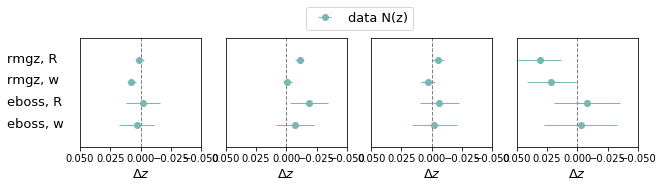

In [257]:
# dz_eboss = runs_data['eboss_R_w'].sompz_mean['wdm_br'][i]-runs_data['eboss_R_w'].Nz_mean['wdm_br'][i]
# dz_rm = runs_data['rmg_R_w'].sompz_mean[est][i]-runs_data['rmg_R_w'].Nz_mean[est][i]
# array_data.append(dz_eboss-dz_rm)
        
#keyz = ['y1']#, 'wdm_brcorr', 'wdm_br', 'wdm']
keyz = runs_data.keys()#, 'wdm_brcorr', 'wdm_br', 'wdm']
dict_data = dict()
for i in range(4):
    array_data=dict()
    dz_eboss = runs_data['eboss_R_w'].sompz_mean['wdm_br'][i]-runs_data['eboss_R_w'].Nz_mean['wdm_br'][i]
    dz_rm = runs_data['rmg_R_w'].sompz_mean['wdm_brcorr'][i]-runs_data['rmg_R_w'].Nz_mean['wdm_brcorr'][i]
    dz_eboss_R = runs_data['eboss_R'].sompz_mean['wdm_br'][i]-runs_data['eboss_R'].Nz_mean['wdm_br'][i]
    dz_rm_R = runs_data['rmg_R'].sompz_mean['wdm_brcorr'][i]-runs_data['rmg_R'].Nz_mean['wdm_brcorr'][i]
    dz_eboss_w = runs_data['eboss_w'].sompz_mean['wdm_br'][i]-runs_data['eboss_w'].Nz_mean['wdm_br'][i]
    dz_rm_w = runs_data['rmg_w'].sompz_mean['wdm_brcorr'][i]-runs_data['rmg_w'].Nz_mean['wdm_brcorr'][i]
    array_data['ebossw' ] = dz_eboss-dz_eboss_R
    array_data['ebossR' ] = dz_eboss-dz_eboss_w
    array_data['rmw' ] = dz_rm-dz_rm_R
    array_data['rmR' ] = dz_rm-dz_rm_w
    array_data['ebossw_err' ] =  runs_data['eboss_R_w'].Nz_mean_err['wdm_br'][i]+runs_data['eboss_R'].Nz_mean_err['wdm_br'][i]
    array_data['ebossR_err' ] =  runs_data['eboss_R_w'].Nz_mean_err['wdm_br'][i]+runs_data['eboss_w'].Nz_mean_err['wdm_br'][i]
    array_data['rmw_err' ] = runs_data['rmg_R_w'].Nz_mean_err['wdm_brcorr'][i]+runs_data['rmg_R'].Nz_mean_err['wdm_brcorr'][i]
    array_data['rmR_err' ] = runs_data['rmg_R_w'].Nz_mean_err['wdm_brcorr'][i]+runs_data['rmg_w'].Nz_mean_err['wdm_brcorr'][i]

    dict_data[i] = array_data
    

    

xmin=-0.05
xmax=-0.05
truth = np.zeros(4)
plt.figure(figsize=(10,2))
ax0 = plt.subplot(141)
yy = np.array([dict_data[0]['ebossw'],dict_data[0]['ebossR'], dict_data[0]['rmw'], dict_data[0]['rmR']])
yyerr = np.array([dict_data[0]['ebossw_err'],dict_data[0]['ebossR_err'], dict_data[0]['rmw_err'], dict_data[0]['rmR_err']])
plot_1d(yy,  yyerr, 0, ax0, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
plt.xlim(-xmin,xmax)

ax1 = plt.subplot(142)
yy = np.array([dict_data[1]['ebossw'],dict_data[1]['ebossR'], dict_data[1]['rmw'], dict_data[1]['rmR']])
yyerr = np.array([dict_data[1]['ebossw_err'],dict_data[1]['ebossR_err'], dict_data[1]['rmw_err'], dict_data[1]['rmR_err']])
plot_1d(yy,  yyerr, 0, ax1, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')

plt.xlim(-xmin,xmax)

ax2 = plt.subplot(143)
yy = np.array([dict_data[2]['ebossw'],dict_data[2]['ebossR'], dict_data[2]['rmw'], dict_data[2]['rmR']])
yyerr = np.array([dict_data[2]['ebossw_err'],dict_data[2]['ebossR_err'], dict_data[2]['rmw_err'], dict_data[2]['rmR_err']])
plot_1d(yy, yyerr, 0, ax2, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')

plt.xlim(-xmin,xmax)

ax3 = plt.subplot(144)
yy = np.array([dict_data[3]['ebossw'],dict_data[3]['ebossR'], dict_data[3]['rmw'], dict_data[3]['rmR']])
yyerr = np.array([dict_data[3]['ebossw_err'],dict_data[3]['ebossR_err'], dict_data[3]['rmw_err'], dict_data[3]['rmR_err']])
plot_1d(yy,  yyerr, 0, ax3, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')

plt.xlim(-xmin,xmax)
plt.legend(bbox_to_anchor=(-0.8,1.35),ncol = 3, fontsize=13)
uu = 0.47
# #plt.text(uu,11.8,"Scale cut", fontsize=13)
# #plt.text(uu,10.8,r"$12 h^{-1}$ Mpc", fontsize=13)
#plt.text(uu,0.8 ,'ciao', fontsize=13)
# #plt.text(uu,8.8 ,labb[9], fontsize=13)
# #plt.text(uu,7.8 ,labb[8], fontsize=13)
# #plt.text(uu,6.8 ,labb[7], fontsize=13)
# #plt.text(uu,5.8 ,labb[6], fontsize=13)
# plt.text(uu,4.8 ,labb[5], fontsize=13)
# plt.text(uu,3.8 ,labb[4], fontsize=13)
plt.text(uu,2.9 ,'rmgz, R', fontsize=13)
plt.text(uu,1.9 ,'rmgz, w', fontsize=13)
plt.text(uu,0.9 ,'eboss, R', fontsize=13)
plt.text(uu,-0.1,'eboss, w', fontsize=13)
# plt.tight_layout()
# plt.legend(bbox_to_anchor=(-0.2,1.15),ncol = 3, fontsize=13)
plt.savefig('./mean_shifts_response_w.pdf',bbox_inches='tight')





[-0.02689607 -0.0176929 ]
[-0.00499835 -0.01097655]
[-0.0396315  -0.02540022]
[-0.00284823 -0.01108393]
[-0.00136084 -0.01757308]
[-0.00926474 -0.01183937]
[-0.03004499 -0.05138765]
[0.00249908 0.04713303]


Text(0.45,-0.2,'rmg_R')

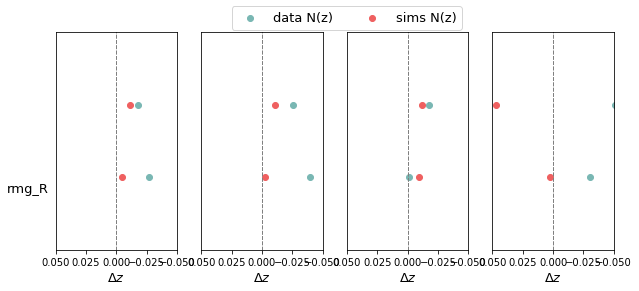

In [159]:
# dz_eboss = runs_data['eboss_R_w'].sompz_mean['wdm_br'][i]-runs_data['eboss_R_w'].Nz_mean['wdm_br'][i]
# dz_rm = runs_data['rmg_R_w'].sompz_mean[est][i]-runs_data['rmg_R_w'].Nz_mean[est][i]
# array_data.append(dz_eboss-dz_rm)
        
#keyz = ['y1']#, 'wdm_brcorr', 'wdm_br', 'wdm']
keyz = runs_data.keys()#, 'wdm_brcorr', 'wdm_br', 'wdm']
dict_data = dict()
est = 'wdm_br'
for i in range(4):
    array_data=dict()
    dz_eboss = runs_data['eboss_R_w'].sompz_mean['wdm_br'][i]-runs_data['eboss_R_w'].Nz_mean['wdm_br'][i]
    dz_rm = runs_data['rmg_R_w'].sompz_mean['wdm_brcorr'][i]-runs_data['rmg_R_w'].Nz_mean['wdm_brcorr'][i]
    array_data['500_1500'] = (dz_eboss-dz_rm)
    dz_eboss = runs_data['eboss_R_w_1500_5000'].sompz_mean['wdm_br'][i]-runs_data['eboss_R_w_1500_5000'].Nz_mean['wdm_br'][i]
    dz_rm = runs_data['rmg_R_w_1500_5000'].sompz_mean['wdm_brcorr'][i]-runs_data['rmg_R_w_1500_5000'].Nz_mean['wdm_brcorr'][i]
    array_data['1500_5000' ] = (dz_eboss-dz_rm)
    dict_data[i] = array_data
        

dict_sims = dict()
est = 'wdm_br'
for i in range(4):
    array_sims=dict()
    dz_eboss = runs_sims['eboss_w'].sompz_mean['wdm_br'][i]-runs_sims['eboss_w'].Nz_mean['wdm_br'][i]
    dz_rm = runs_sims['rmgz'].sompz_mean['wdm_brcorr'][i]-runs_sims['rmgz'].Nz_mean['wdm_brcorr'][i]
    array_sims['500_1500'] = (dz_eboss-dz_rm)
    dz_eboss = runs_sims['eboss_w_1500_5000'].sompz_mean['wdm_br'][i]-runs_sims['eboss_w_1500_5000'].Nz_mean['wdm_br'][i]
    dz_rm = runs_sims['rmgz_1500_5000kpc'].sompz_mean['wdm_brcorr'][i]-runs_sims['rmgz_1500_5000kpc'].Nz_mean['wdm_brcorr'][i]
    array_sims['1500_5000'] = (dz_eboss-dz_rm)
    dict_sims[i] = array_sims

    

xmin=-0.05
xmax=-0.05
truth = np.zeros(4)
plt.figure(figsize=(10,4))
ax0 = plt.subplot(141)
yy = np.array([dict_data[0]['500_1500'],dict_data[0]['1500_5000']])
plot_1d(yy, 0, ax0, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
yy = np.array([dict_sims[0]['500_1500'],dict_sims[0]['1500_5000']])
plot_1d(yy , 0, ax0, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)

ax1 = plt.subplot(142)
yy = np.array([dict_data[1]['500_1500'],dict_data[1]['1500_5000']])
plot_1d(yy, 0, ax1, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
yy = np.array([dict_sims[1]['500_1500'],dict_sims[1]['1500_5000']])
plot_1d(yy , 0, ax1, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)

ax2 = plt.subplot(143)
yy = np.array([dict_data[2]['500_1500'],dict_data[2]['1500_5000']])
plot_1d(yy, 0, ax2, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
yy = np.array([dict_sims[2]['500_1500'],dict_sims[2]['1500_5000']])
plot_1d(yy , 0, ax2, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)

ax3 = plt.subplot(144)
yy = np.array([dict_data[3]['500_1500'],dict_data[3]['1500_5000']])
plot_1d(yy, 0, ax3, r'$\Delta z$', legend=0,color=c_23,lab='data N(z)')
yy = np.array([dict_sims[3]['500_1500'],dict_sims[3]['1500_5000']])
plot_1d(yy , 0, ax3, r'$\Delta z$', legend=0,lab='sims N(z)')
plt.xlim(-xmin,xmax)
plt.legend(bbox_to_anchor=(-0.2,1.15),ncol = 3, fontsize=13)
# uu = 0.45
# #plt.text(uu,11.8,"Scale cut", fontsize=13)
# #plt.text(uu,10.8,r"$12 h^{-1}$ Mpc", fontsize=13)
#plt.text(uu,0.8 ,'ciao', fontsize=13)
# #plt.text(uu,8.8 ,labb[9], fontsize=13)
# #plt.text(uu,7.8 ,labb[8], fontsize=13)
# #plt.text(uu,6.8 ,labb[7], fontsize=13)
# #plt.text(uu,5.8 ,labb[6], fontsize=13)
# plt.text(uu,4.8 ,labb[5], fontsize=13)
# plt.text(uu,3.8 ,labb[4], fontsize=13)
#plt.text(uu,2.8 ,keyz[3], fontsize=13)
#plt.text(uu,1.8 ,keyz[2], fontsize=13)
plt.text(uu,0.8 ,'small, fontsize=13)
plt.text(uu,-0.2,keyz[0], fontsize=13)
# plt.tight_layout()
# plt.legend(bbox_to_anchor=(-0.2,1.15),ncol = 3, fontsize=13)
# #plt.savefig('./figures_x_paper/mean_shifts_cosmosis.pdf',bbox_inches='tight')





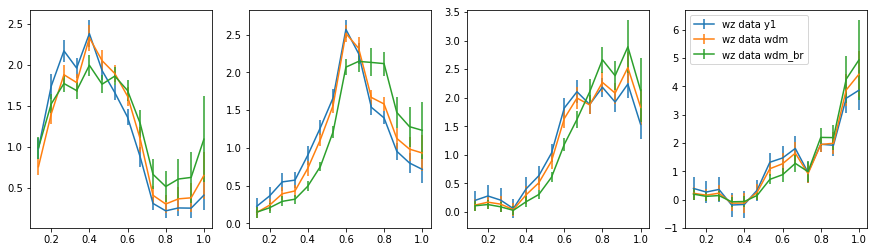

In [138]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
for i in range(4):
    est = 'y1'
    ax[i].errorbar(runs_data['eboss_R_w'].z, runs_data['eboss_R_w'].Nz[est][i,:,0], runs_data['eboss_R_w'].Nz_err[est][i,:], label='wz data {0}'.format(est))         
    est = 'wdm'
    ax[i].errorbar(runs_data['eboss_R_w'].z, runs_data['eboss_R_w'].Nz[est][i,:,0], runs_data['eboss_R_w'].Nz_err[est][i,:], label='wz data {0}'.format(est))         
    est = 'wdm_br'
    ax[i].errorbar(runs_data['eboss_R_w'].z, runs_data['eboss_R_w'].Nz[est][i,:,0], runs_data['eboss_R_w'].Nz_err[est][i,:], label='wz data {0}'.format(est))         
plt.legend()

In [122]:
runs_data.keys()

['rmg_R',
 'rmg_R_w',
 'rmg_w',
 'eboss_R_w_1500_5000',
 'eboss_w',
 'eboss_R',
 'rmg_R_w_1500_5000',
 'eboss_R_w',
 'rmg',
 'eboss',
 'rmg_higher_R',
 'eboss_R_w_25_rm']

KeyError: 'eboss_w_1500_5000'

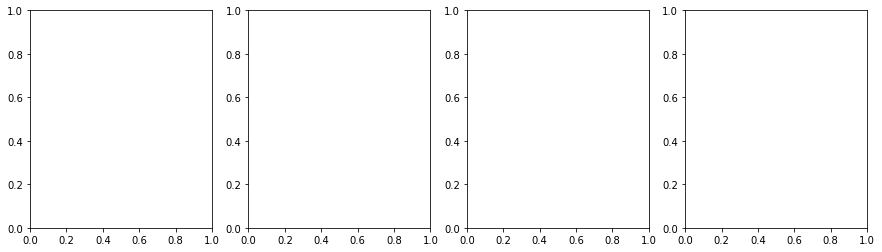

In [136]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))
est = 'wdm_brcorr'
est_eboss = 'wdm_br'
sc = '_1500_5000'

    
for i in range(4):
    try:
        ax[i].errorbar(runs_data['eboss_w'].z, runs_data['eboss_w'+sc].Nz[est_eboss][i,:,0], runs_data['eboss_w'+sc].Nz_err[est_eboss][i,:], label='wz data {0}'.format(est))         
    except:
        ax[i].errorbar(runs_data['eboss_w'].z, runs_data['eboss_w'+sc].Nz['wdm_br'][i,:,0], runs_data['eboss_w'+sc].Nz_err['wdm_br'][i,:], label='wz data {0}'.format(est))         
 
        
    ax[i].errorbar(runs_data['rmg_R_w'].z, runs_data['rmg_R_w'+sc].Nz[est][i,:,0], runs_data['rmg_w'+sc].Nz_err[est][i,:], label='wz data {0}'.format(est))         
    ax[i].errorbar(runs_data['rmg_higher_R'].z, runs_data['rmg_higher_R'+sc].Nz[est][i,:,0], runs_data['rmg_higher_R'+sc].Nz_err[est][i,:], label='wz data {0}'.format(est))         

    
plt.suptitle('eBOSS wz - data vs sims')
plt.legend()

In [ ]:
for method in runs_sims.keys():
est = 'wdm_brcorr '
'{0:2.3f}'.format(runs_data[method].sompz_mean[est][i]-runs_data[method].Nz_mean[est][i])
'{0:2.3f}'.format(runs_sims[method].sompz_mean[est][i]-runs_sims[method].Nz_mean[est][i])


In [ ]:
for method in runs_sims.keys():
est = 'wdm_brcorr '
'{0:2.3f}'.format(runs_data[method].Nz_mean[est][i]runs_data[method].Nz_mean[est][i])
'{0:2.3f}'.format(runs_sims[method].sompz_mean[est][i]-runs_sims[method].Nz_mean[est][i])


In [ ]:
'''
printa:

eboss-rmg y1
eboss-rmg w_dm
eboss-rmg w_dm b
eboss-rmg w_dm b corr


rmg y1 -rmg y1 dm (compare to marco's plot last line)
rmg w_dm b corr - mg w_dm b  compare to marco's plot first and third lines


eboss y3 small scales vs eboss y3 large scales
rmg y3 small scales vs rmg y3 large scales
'''

In [60]:
1

1

/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationW

(0.098, 0.29800000000000004)

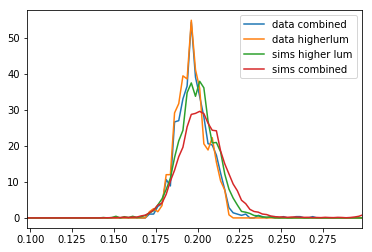

In [217]:
import h5py
import numpy as np
xx = 1
mastercat_v = '12_3_19'

path_mastercat = '/project/projectdirs/des/www/y3_cats/Y3_mastercat_'+mastercat_v+'.h5'
path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'


mastercat = h5py.File(path_mastercat,'r')
zspec_mst = np.array(mastercat['catalog']['redmagic']['combined_sample_fid']['zspec'])
zrmg_mst = np.array(mastercat['catalog']['redmagic']['combined_sample_fid']['zredmagic'])
zrmg_mst= (zrmg_mst[zspec_mst>-1])
zspec_mst = (zspec_mst[zspec_mst>-1])

edg = np.linspace(0.15,0.95,26)
cntr = 0.5*(edg[1:]+edg[:-1])
edg_hr = np.linspace(0.,1.5,601)
cntr_hr = 0.5*(edg_hr[1:]+edg_hr[:-1])
corr = np.zeros(25)
for i in range(25):
    mask1 = (zrmg_mst>edg[i]) & ((zrmg_mst<edg[i+1]))
    #mask1 = (zspec_mst>edg[i]) & ((zspec_mst<edg[i+1]))
    nzh,_ = np.histogram(zspec_mst[mask1],bins=edg_hr,normed=True)
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    if i==xx:
        plt.plot(cntr_hr,nzh,label='data combined')
    corr[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
#corr = np.sqrt(corr)
#plt.plot(cntr,corr)



zspec_mst = np.array(mastercat['catalog']['redmagic']['higherlum']['zspec'])
zrmg_mst = np.array(mastercat['catalog']['redmagic']['higherlum']['zredmagic'])
zrmg_mst= (zrmg_mst[zspec_mst>-1])
zspec_mst = (zspec_mst[zspec_mst>-1])

edg = np.linspace(0.15,0.95,26)
cntr = 0.5*(edg[1:]+edg[:-1])
edg_hr = np.linspace(0.,1.5,601)
cntr_hr = 0.5*(edg_hr[1:]+edg_hr[:-1])
corr = np.zeros(25)
for i in range(25):
    mask1 = (zrmg_mst>edg[i]) & ((zrmg_mst<edg[i+1]))
    #mask1 = (zspec_mst>edg[i]) & ((zspec_mst<edg[i+1]))
    nzh,_ = np.histogram(zspec_mst[mask1],bins=edg_hr,normed=True)
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    if i==xx:
        plt.plot(cntr_hr,nzh,label='data higherlum')
    corr[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
#corr = np.sqrt(corr)
#plt.plot(cntr,corr)





path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'
version = 'v1.9.8_Y3a'
mastercat_sims = h5py.File('/global/cscratch1/sd/jderose/BCC/Chinchilla/Herd/Chinchilla-3/sampleselection/Y3a_old/Buzzard-3_'+version+'_mastercat.h5','r')


# load redshifts into memory for subsequent tests *******************

zredmagic_tot = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zredmagic'])
zspec_tot = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zspec'])
mag = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zmag'])#.keys()

import timeit
corr1 = np.zeros(25)
for i in range(25):

    st0 = timeit.default_timer()
    mask1 = (zredmagic_tot>edg[i]) & ((zredmagic_tot<edg[i+1]))

    st = timeit.default_timer()
    
    nzh,_ = np.histogram(zspec_tot[mask1],bins=edg_hr,normed=True)
    
    end = timeit.default_timer()
    
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    if i==xx:
        plt.plot(cntr_hr,nzh,label='sims higher lum')
        xm = (edg[i+1] +edg[i])*0.5
    corr1[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
corr_sims = np.sqrt(corr1)




# load redshifts into memory for subsequent tests *******************

zredmagic_tot = np.array(mastercat_sims['catalog']['redmagic']['combined_sample_fid']['zredmagic'])
zspec_tot = np.array(mastercat_sims['catalog']['redmagic']['combined_sample_fid']['zspec'])
mag = np.array(mastercat_sims['catalog']['redmagic']['combined_sample_fid']['zmag'])#.keys()

import timeit
corr1 = np.zeros(25)
for i in range(25):

    st0 = timeit.default_timer()
    mask1 = (zredmagic_tot>edg[i]) & ((zredmagic_tot<edg[i+1]))

    st = timeit.default_timer()
    
    nzh,_ = np.histogram(zspec_tot[mask1],bins=edg_hr,normed=True)
    
    end = timeit.default_timer()
    
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],50000),bins=edg_hr,normed=True)
    if i==xx:
        plt.plot(cntr_hr,nzh,label='sims combined')
        xm = (edg[i+1] +edg[i])*0.5
    corr1[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
corr_sims = np.sqrt(corr1)


plt.legend()
plt.xlim([xm-0.1,xm+0.1])





/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/global/u2/m/mgatti/.conda/envs/myenv_up/lib/python2.7/site-packages/ipykernel_launcher.py:74: VisibleDeprecationW

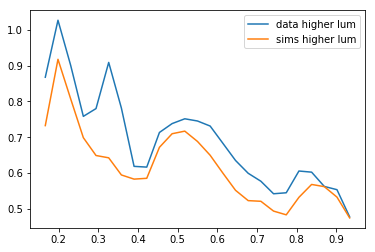

In [506]:
import h5py
import numpy as np
xx = 10
mastercat_v = '12_3_19'

path_mastercat = '/project/projectdirs/des/www/y3_cats/Y3_mastercat_'+mastercat_v+'.h5'
path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'


mastercat = h5py.File(path_mastercat,'r')
zspec_mstf = np.array(mastercat['catalog']['redmagic']['higherlum']['zspec'])
zrmg_mstf = np.array(mastercat['catalog']['redmagic']['higherlum']['zredmagic'])
zrmg_mst= (zrmg_mstf[zspec_mstf>-1])
zspec_mst = (zspec_mstf[zspec_mstf>-1])

edg = np.linspace(0.15,0.95,26)
cntr = 0.5*(edg[1:]+edg[:-1])
edg_hr = np.linspace(0.,1.5,401)
cntr_hr = 0.5*(edg_hr[1:]+edg_hr[:-1])
corr = np.zeros(25)
corr1 = np.zeros(25)
for i in range(25):
    mask1 = (zrmg_mst>edg[i]) & ((zrmg_mst<edg[i+1]))
    #mask1 = (zspec_mst>edg[i]) & ((zspec_mst<edg[i+1]))
    
    
    
    #maskz_sub = (zrmg_mst>edg[i]) & (zrmg_mst<edg[i+1])
    #maskz = (zrmg_mstf>edg[i]) & (zrmg_mstf<edg[i+1])
    #ww1= match_distribution(z_mag[maskz],z_mag_sub[maskz_sub], 40)
    
    
    nzh1,_ = np.histogram(zspec_mst[mask1],bins=edg_hr,normed=True)
    
    #nzh,_ = np.histogram(zspec_mst[mask1],weights=ww1,bins=edg_hr,normed=True)
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],500),bins=edg_hr,normed=True)
    #if i==xx:
        #plt.plot(cntr_hr,nzh)
    #corr[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
    corr1[i] = np.trapz(nzh1**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
corr_data = np.sqrt(corr1)
#corr_dataw = np.sqrt(corr)
plt.plot(cntr,corr_data,label='data higher lum')
#plt.plot(cntr,corr_dataw,label='data higher lum w')




path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'
version = 'v1.9.8_Y3a'
mastercat_sims = h5py.File('/global/cscratch1/sd/jderose/BCC/Chinchilla/Herd/Chinchilla-3/sampleselection/Y3a/Buzzard-3_'+version+'_mastercat.h5','r')


# load redshifts into memory for subsequent tests *******************

zredmagic_tot = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zredmagic'])
zspec_tot = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zspec'])
mag = np.array(mastercat_sims['catalog']['redmagic']['higherlum']['zmag'])#.keys()

import timeit
corr1 = np.zeros(25)
for i in range(25):

    st0 = timeit.default_timer()
    mask1 = (zredmagic_tot>edg[i]) & ((zredmagic_tot<edg[i+1]))

    st = timeit.default_timer()
    
    nzh,_ = np.histogram(zspec_tot[mask1],bins=edg_hr,normed=True)
    
    end = timeit.default_timer()
    
    nzh_u,_ = np.histogram(np.linspace(edg[i],edg[i+1],500),bins=edg_hr,normed=True)
    if i==xx:
        #plt.plot(cntr_hr,nzh,label='sims higher lum')
        xm = (edg[i+1] +edg[i])*0.5
    corr1[i] = np.trapz(nzh**2,cntr_hr)/np.trapz(nzh_u**2,cntr_hr)#
corr_sims_hr = np.sqrt(corr1)
plt.plot(cntr,corr_sims_hr,label='sims higher lum')
plt.legend()


path_to_save = '/global/cscratch1/sd/mgatti/clustering_z/data/'
save_obj(path_to_save+'/corr_bias_n2',[corr_sims_hr,corr_data])





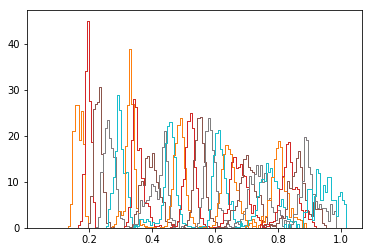

In [326]:
for i in range(25):
    maskz_sub = (zrmg_mst_sub>edg[i]) & (zrmg_mst_sub<edg[i+1])
    maskz = (zrmg_mst>edg[i]) & (zrmg_mst<edg[i+1])
    _=plt.hist(zspec_mst[maskz],normed=True,histtype='step',bins=np.linspace(edg[i]-0.1,edg[i]+0.1,30))
    _=plt.hist(zspec_mst_sub[maskz_sub],normed=True,histtype='step',label='sub',bins=np.linspace(edg[i]-0.1,edg[i]+0.1,30))
    #plt.legend()
    #plt.show()

In [332]:
z_mag[maskz]#,z_mag_sub[maskz_sub]

array([17.523615, 17.134647, 17.196999, ..., 16.67053 , 17.390003,
       16.635256], dtype=float32)

In [285]:
def match_distribution(z1, z2, z_bins):
    
    rhist, rbins = np.histogram(z1, bins=z_bins, normed=True)
    rhist_s, rbins_s = np.histogram(z2, bins=z_bins, normed=True)
    cumul_weight = np.zeros(len(rhist))
    cumul_weight1 = np.zeros(len(rhist))
    inds = np.digitize(z2, rbins)
    probr = np.zeros(len(z2))
    for n in range(z2.size):
        if ((inds[n]>0.) & (inds[n]<len(rhist))):
            if (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1]) != np.inf:
                if (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1]) != np.nan:
                    probr[n] = (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1])

    for n in range(z2.size):
        if ((inds[n] > 0.) & (inds[n] < len(rhist))):
            if (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1]) != np.inf:
                if (rhist[inds[n] - 1]) / (rhist_s[inds[n] - 1]) != np.nan:
                    cumul_weight[inds[n]]+=probr[n]
    for i in range(len(rhist)):
        cumul_weight1[i]=(rhist[i]) / (rhist_s[i])
    return probr / float(probr.sum())
    
    #return np.ones(len(z1))


In [334]:
for i in range(25):
    maskz_sub = (zrmg_mst>edg[i]) & (zrmg_mst<edg[i+1])
    maskz = (zrmg_mst>edg[i]) & (zrmg_mst<edg[i+1])
    ww1= match_distribution(z_mag[maskz],z_mag_sub[maskz_sub], 40)
    _=plt.hist(z_mag[maskz],normed=True,histtype='step',bins=np.linspace(15,23,50))
    _=plt.hist(z_mag_sub[maskz_sub],normed=True,histtype='step',label='sub',bins=np.linspace(15,23,50))
    _=plt.hist(z_mag_sub[maskz_sub],weights = ww1,normed=True,histtype='step',label='sub match',bins=np.linspace(15,23,50))
    plt.legend()
    plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2686519 but corresponding boolean dimension is 46185